perform Dominance Analysis (https://dominance-analysis.github.io/dominance-analysis/) to quantify response (plasma cell differentiation/pseudotime) single-cell variation explained by features (including secRecon subsystem average expression, subsystem PPI activity, Ig subtype expression, biological processes such as translation, oxidative phosphorylation)

In [1]:
import pandas as pd
import numpy as np
from dominance_analysis import Dominance
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

Loading BokehJS ...

In [6]:
# read secRecon ontology hierarchies
# ont_c2p # subsystem: parent term level 1
# ont_c2p_2 # subsystem: parent term level 2

with open('../data/ont_c2p.pickle', 'rb') as f:
    ont_c2p = pickle.load(f)
    
with open('../data/ont_c2p_2.pickle', 'rb') as f:
    ont_c2p_2 = pickle.load(f)

In [34]:
# read in data, containing features and responses for Dominance Analysis
data = pd.read_pickle('../data/dominance_analysis/rna_pseudotime_ppiscore_relimp-input.pkl')
# to check if any cols have NAs
# data.isna().sum(0)[data.isna().sum(0) > 0]


### drop cols if contains nans; this should not be needed with latest secRecon genesets
# data.drop('Autophagy (Proteostasis)_ppi',axis=1,inplace=True)
data

,leiden,Ig,IgL,IgH,sec,sample,dpt_pseudotime,IgG_ADT,Proteostasis_score,Protein conformation_score,...,Co-translational translocation_ppi,Lysosomes_ppi,Cytoskeletal remodeling_ppi,Golgi organization_ppi,Glycosphingolipid_ppi,Glycosylation_ppi,ATF6 pathway_ppi,GOBP_CYTOPLASMIC_TRANSLATION,GOBP_OXIDATIVE_PHOSPHORYLATION,hc_avgexpr
AAACCCAAGTACTGTC-1-0,1,G,kappa,G1,x,0,0.884599,4.770685,0.435029,0.522524,...,1.819897,0.013196,0.371228,0.016733,0.015527,0.024130,0.000000,2.052834,0.935794,2.482668
AAACCCAAGTGAATAC-1-0,3,M,kappa,M,x,0,0.933548,4.653960,0.168712,0.162781,...,0.679862,0.015434,0.120019,0.000000,0.000000,0.011048,0.000000,0.984764,0.396314,0.231794
AAACCCAGTCCACAGC-1-0,1,G,kappa,G1,hi,0,0.906659,5.710427,0.552796,0.601564,...,2.476017,0.018696,0.453853,0.000000,0.001241,0.022662,0.000000,2.190161,0.988762,1.882263
AAACCCATCACAGTGT-1-0,1,M,kappa,M,hi,0,0.783142,5.556828,0.339925,0.388061,...,0.876605,0.099396,0.281816,0.000000,0.044770,0.022601,0.000000,1.621707,0.714259,0.638683
AAACCCATCCCTCTCC-1-0,1,G,kappa,G1,hi,0,0.892763,5.252274,0.429170,0.561533,...,1.435594,0.068564,0.363887,0.025068,0.009090,0.022926,0.419445,1.917427,0.763462,2.502022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCGACTCCT-1-2,7,M,lambda,M,x,2,0.934061,4.744932,0.323393,0.320241,...,0.663635,0.028876,0.304052,0.000000,0.002596,0.009699,0.000000,1.566272,0.795322,-0.539010
TTTGTTGAGGTACAAT-1-2,7,M,lambda,M,x,2,0.947517,5.624018,0.299398,0.303794,...,0.971451,0.016065,0.172519,0.032446,0.000000,0.011484,0.319740,1.516106,0.703687,-0.440936
TTTGTTGAGTAACGAT-1-2,5,A,kappa,A,lo,2,0.915166,4.465908,0.339964,0.381117,...,1.325469,0.029162,0.361583,0.000000,0.003031,0.009523,0.000000,1.813164,0.973084,-0.861214
TTTGTTGCACGTTGGC-1-2,5,A,kappa,A,lo,2,0.968185,3.761200,0.341057,0.412427,...,1.154902,0.006553,0.193638,0.000000,0.000000,0.005915,0.000000,1.535303,0.768697,-0.451933


# create subsets of data for analysis
perform aggregate population analysis followed by subpopulation analysis (e.g. group by Leiden cluster, Ig Heavy chain/Light chain subtype)

In [19]:
# use IgG HC expression as a surrogate for IgG transcription
transc = ['hc_avgexpr']
goterms = [i for i in data.columns if 'GOBP' in i]

In [20]:
# all cells to predict pseudotime/igg; no subsetting
df_data = {}
df_data['pst_score'] = data[['dpt_pseudotime','IgG_ADT'] + [i for i in data.columns if '_score' in i]]
df_data['pst_ppi'] = data[['dpt_pseudotime','IgG_ADT'] + [i for i in data.columns if '_ppi' in i]]
df_data['igg_score'] = data[['dpt_pseudotime','IgG_ADT'] + [i for i in data.columns if '_score' in i]]
df_data['igg_ppi'] = data[['dpt_pseudotime','IgG_ADT'] + [i for i in data.columns if '_ppi' in i]]

# added igg and pseudotime in respective data as another feature -- is igg <> pseudotime potentially explaining variability?b

In [21]:
# subset data for IgG population
g_data = {}
g_subdf = data[data['Ig'] == 'G'].copy()
print(g_subdf.shape)

g_data['G'+'-pst_score'] = g_subdf[['dpt_pseudotime','IgG_ADT'] + [i for i in data.columns if '_score' in i]]
g_data['G'+'-pst_ppi'] = g_subdf[['dpt_pseudotime','IgG_ADT'] + [i for i in data.columns if '_ppi' in i]]
g_data['G'+ '-igg_score'] = g_subdf[['dpt_pseudotime','IgG_ADT'] + [i for i in data.columns if '_score' in i]]
g_data['G'+ '-igg_ppi'] = g_subdf[['dpt_pseudotime','IgG_ADT'] + [i for i in data.columns if '_ppi' in i]]

(8106, 144)


In [24]:
# subset data for IgG population, add transcription and GO-BP scoring

g_data2 = {}
g_subdf = data[data['Ig'] == 'G'].copy()
print(g_subdf.shape)

g_data2['G'+'-pst_score'] = g_subdf[['dpt_pseudotime','IgG_ADT'] + [i for i in data.columns if '_score' in i]+transc+goterms]
g_data2['G'+'-pst_ppi'] = g_subdf[['dpt_pseudotime','IgG_ADT'] + [i for i in data.columns if '_ppi' in i]+transc+goterms]
g_data2['G'+ '-igg_score'] = g_subdf[['dpt_pseudotime','IgG_ADT'] + [i for i in data.columns if '_score' in i]+transc+goterms]
g_data2['G'+ '-igg_ppi'] = g_subdf[['dpt_pseudotime','IgG_ADT'] + [i for i in data.columns if '_ppi' in i]+transc+goterms]

(8106, 144)


In [25]:
# subset per HC expressing population
hc_data = {}
for hc in set(data['Ig']):
#     if lc != 'x':
    hc_df = data[data['Ig'] == hc].copy()
    print(hc,hc_df.shape)

    hc_data[hc+'-pst_score'] = hc_df[['dpt_pseudotime','IgG_ADT'] + [i for i in data.columns if '_score' in i]]
    hc_data[hc+'-pst_ppi'] = hc_df[['dpt_pseudotime','IgG_ADT'] + [i for i in data.columns if '_ppi' in i]]
#     hc_data[hc+'-igg_score'] = hc_df[['dpt_pseudotime','IgG_ADT'] + [i for i in data.columns if '_score' in i]]
#     hc_data[hc+'-igg_ppi'] = hc_df[['dpt_pseudotime','IgG_ADT'] + [i for i in data.columns if '_ppi' in i]]

G (8106, 144)
M (2004, 144)
x (1329, 144)
A (1453, 144)


In [26]:
# subset per LC expressing population

lc_data = {}
for lc in set(data['IgL']):
    if lc != 'x':
        lc_df = data[data['IgL'] == lc].copy()
        print(lc,lc_df.shape)
        
        lc_data[lc+'-pst_score'] = lc_df[['dpt_pseudotime','IgG_ADT'] + [i for i in data.columns if '_score' in i]]
        lc_data[lc+'-pst_ppi'] = lc_df[['dpt_pseudotime','IgG_ADT'] + [i for i in data.columns if '_ppi' in i]]
        lc_data[lc+'-igg_score'] = lc_df[['dpt_pseudotime','IgG_ADT'] + [i for i in data.columns if '_score' in i]]
        lc_data[lc+'-igg_ppi'] = lc_df[['dpt_pseudotime','IgG_ADT'] + [i for i in data.columns if '_ppi' in i]]

lambda (5172, 144)
kappa (6903, 144)


In [27]:
# separate by leiden cluster
c_data = {}
for c in set(data['leiden']):
    c_df = data[data['leiden'] == c].copy()
    print(c,c_df.shape)
    
    c_data[str(c)+'-pst_score'] = c_df[['dpt_pseudotime','IgG_ADT'] + [i for i in data.columns if '_score' in i]]
    c_data[str(c)+'-pst_ppi'] = c_df[['dpt_pseudotime','IgG_ADT'] + [i for i in data.columns if '_ppi' in i]]
    c_data[str(c)+'-igg_score'] = c_df[['dpt_pseudotime','IgG_ADT'] + [i for i in data.columns if '_score' in i]]
    c_data[str(c)+'-igg_ppi'] = c_df[['dpt_pseudotime','IgG_ADT'] + [i for i in data.columns if '_ppi' in i]]

10 (332, 144)
2 (2234, 144)
6 (817, 144)
0 (2497, 144)
4 (971, 144)
7 (754, 144)
5 (840, 144)
9 (388, 144)
3 (1251, 144)
1 (2305, 144)
8 (503, 144)


In [28]:
# separate by leiden cluster, add transcription and GO-BP scoring
c_data2 = {}
for c in set(data['leiden']):
    c_df = data[data['leiden'] == c].copy()
    print(c,c_df.shape)
    
    c_data2[str(c)+'-pst_score'] = c_df[['dpt_pseudotime','IgG_ADT'] + [i for i in data.columns if '_score' in i]+transc+goterms]
    c_data2[str(c)+'-pst_ppi'] = c_df[['dpt_pseudotime','IgG_ADT'] + [i for i in data.columns if '_ppi' in i]+transc+goterms]
    c_data2[str(c)+'-igg_score'] = c_df[['dpt_pseudotime','IgG_ADT'] + [i for i in data.columns if '_score' in i]+transc+goterms]
    c_data2[str(c)+'-igg_ppi'] = c_df[['dpt_pseudotime','IgG_ADT'] + [i for i in data.columns if '_ppi' in i]+transc+goterms]

10 (332, 144)
2 (2234, 144)
6 (817, 144)
0 (2497, 144)
4 (971, 144)
7 (754, 144)
5 (840, 144)
9 (388, 144)
3 (1251, 144)
1 (2305, 144)
8 (503, 144)


# Run Dominance Analysis
- multiple linear regression model
- keep default top 15 features for final model/output
- responses are pseudotime and secreted IgG

In [33]:
# dominance analysis for all cells

dom = {}

dom['pst_score'] = Dominance(data=df_data['pst_score'],target='dpt_pseudotime',objective=1,pseudo_r2="mcfadden",data_format=0)# 0.553
dom['pst_ppi'] = Dominance(data=df_data['pst_ppi'],target='dpt_pseudotime',objective=1,pseudo_r2="mcfadden",data_format=0) # 0.713
dom['igg_score'] = Dominance(data=df_data['igg_score'],target='IgG_ADT',objective=1,pseudo_r2="mcfadden",data_format=0)
dom['igg_ppi'] = Dominance(data=df_data['igg_ppi'],target='IgG_ADT',objective=1,pseudo_r2="mcfadden",data_format=0)

for i in [*dom]:
    dom[i].incremental_rsquare()

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Golgi to PM_score', 'Endocytosis_score', 'Post-Golgi_score', 'Clathrin_score', 'Chondroitin sulfate_score', 'Post-translational translocation_score', 'Glycosaminoglycan_score', 'ERpQC_score', 'Vesicle budding_score', 'Endocytic recycling_score', 'Heparan sulfate_score', 'Exosome/secreted_score', 'Translocation_score', 'Co-translational translocation_score', 'Cytoskeletal remodeling_score']

********************  R-Squared of Complete Model :  ********************
R Squared : 0.5489890539196836

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Mislocalized protein degradation_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Targeting to correct compartment/cargo sorting_ppi', 'Clathrin_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'Endocytic recycling_ppi', 'Exosome/secreted_ppi', 'Membrane fusion_ppi', 'Lysosomes_ppi', 'Cytoske

100%|███████████████████████████████████████████| 15/15 [03:41<00:00, 14.75s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:44<00:00, 16.04s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Mislocalized protein degradation_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Targeting to correct compartment/cargo sorting_ppi', 'Clathrin_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'Endocytic recycling_ppi', 'Exosome/secreted_ppi', 'Membrane fusion_ppi', 'Lysosomes_ppi', 'Cytoskeletal remodeling_ppi', 'Glycosphingolipid_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [03:42<00:00, 14.84s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:36<00:00, 15.44s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'Retrotranslocation_score', 'Mislocalized protein degradation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Autophagy (Vesicle trafficking)_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Pre-Golgi_score', 'Ubiquitination_score', 'ERAD_score', 'Translocation_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [03:53<00:00, 15.59s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:39<00:00, 15.68s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'Retrotranslocation_ppi', 'PERK pathway_ppi', 'Multimerization_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Protein folding_ppi', 'Pre-Golgi_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'ER to Golgi (anterograde)_ppi', 'Glycosylation_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [03:50<00:00, 15.35s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:40<00:00, 15.77s/it]

#########################  Variable Dominance Calculation Done!!!!!  #########################



In [29]:
# for all IgG cells
g_dom = {}
for i in [*g_data]:
    print(i)
    if 'pst' in i:
        g_dom[i] = Dominance(data=g_data[i],target='dpt_pseudotime',objective=1,pseudo_r2="mcfadden",data_format=0)
    elif 'igg' in i:
        g_dom[i] = Dominance(data=g_data[i],target='IgG_ADT',objective=1,pseudo_r2="mcfadden",data_format=0)
        
for i in [*g_dom]:
    g_dom[i].incremental_rsquare()

G-pst_score
Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'ER stress response/UPR_score', 'Post-Golgi_score', 'Protein folding_score', 'Targeting to correct compartment/cargo sorting_score', 'Clathrin_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Heparan sulfate_score', 'Cytoskeletal remodeling_score']

********************  R-Squared of Complete Model :  ********************
R Squared : 0.32381867914324736

G-pst_ppi
Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Clathrin_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Exosome/secreted_ppi', 'Cytos

100%|███████████████████████████████████████████| 15/15 [03:45<00:00, 15.06s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:37<00:00, 15.54s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Clathrin_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Exosome/secreted_ppi', 'Cytoskeletal remodeling_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [03:25<00:00, 13.70s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:38<00:00, 15.61s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'Retrotranslocation_score', 'Mislocalized protein degradation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Autophagy (Vesicle trafficking)_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Pre-Golgi_score', 'Ubiquitination_score', 'ERAD_score', 'Translocation_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [03:21<00:00, 13.45s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:40<00:00, 15.74s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'Retrotranslocation_ppi', 'PERK pathway_ppi', 'Multimerization_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Cytoskeletal remodeling_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [03:19<00:00, 13.30s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:41<00:00, 15.79s/it]

#########################  Variable Dominance Calculation Done!!!!!  #########################



In [30]:
# for all IgG cells ## with add'l features
g_dom2 = {}
for i in [*g_data2]:
    print(i)
    if 'pst' in i:
        g_dom2[i] = Dominance(data=g_data2[i],target='dpt_pseudotime',objective=1,pseudo_r2="mcfadden",data_format=0)
    elif 'igg' in i:
        g_dom2[i] = Dominance(data=g_data2[i],target='IgG_ADT',objective=1,pseudo_r2="mcfadden",data_format=0)
        
    g_dom2[i].incremental_rsquare()
    
for i in [*g_dom2]:
    g_dom2[i].incremental_rsquare()

G-pst_score
Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'ER stress response/UPR_score', 'Post-Golgi_score', 'Protein folding_score', 'Targeting to correct compartment/cargo sorting_score', 'Clathrin_score', 'Ubiquitination_score', 'Heparan sulfate_score', 'Cytoskeletal remodeling_score', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

********************  R-Squared of Complete Model :  ********************
R Squared : 0.34282642176533507

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'ER stress response/UPR_score', 'Post-Golgi_score', 'Protein folding_score', 'Targeting to correct compartment/cargo sorting_score', 'Clathrin_score', 'Ubiquitination_score', 'Heparan sulfate_score',

100%|███████████████████████████████████████████| 15/15 [03:22<00:00, 13.51s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:39<00:00, 15.68s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

G-pst_ppi
Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Clathrin_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Exosome/secreted_ppi', 'Cytoskeletal remodeling_ppi', 'GOBP_CYTOPLASMIC_TRANSLATION']

********************  R-Squared of Complete Model :  ********************
R Squared : 0.43557136536670205

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Clathrin_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Exosome/secreted

100%|███████████████████████████████████████████| 15/15 [03:25<00:00, 13.70s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:36<00:00, 15.50s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

G-igg_score
Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'Retrotranslocation_score', 'Mislocalized protein degradation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Translocation_score', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

********************  R-Squared of Complete Model :  ********************
R Squared : 0.30577981307082214

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'Retrotranslocation_score', 'Mislocalized protein degradation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Protein fo

100%|███████████████████████████████████████████| 15/15 [03:26<00:00, 13.78s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:36<00:00, 15.46s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

G-igg_ppi
Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'hc_avgexpr', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

********************  R-Squared of Complete Model :  ********************
R Squared : 0.3230268207128314

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'hc_avgexpr', 'GO

100%|███████████████████████████████████████████| 15/15 [03:22<00:00, 13.53s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:40<00:00, 15.77s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'ER stress response/UPR_score', 'Post-Golgi_score', 'Protein folding_score', 'Targeting to correct compartment/cargo sorting_score', 'Clathrin_score', 'Ubiquitination_score', 'Heparan sulfate_score', 'Cytoskeletal remodeling_score', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [03:26<00:00, 13.75s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:42<00:00, 15.86s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Clathrin_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Exosome/secreted_ppi', 'Cytoskeletal remodeling_ppi', 'GOBP_CYTOPLASMIC_TRANSLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [03:18<00:00, 13.21s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:38<00:00, 15.63s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'Retrotranslocation_score', 'Mislocalized protein degradation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Translocation_score', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [03:21<00:00, 13.41s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:34<00:00, 15.34s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'hc_avgexpr', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [03:23<00:00, 13.57s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:41<00:00, 15.79s/it]

#########################  Variable Dominance Calculation Done!!!!!  #########################



In [34]:
# dominance analysis per HC subpopulation
hc_dom = {}
for i in [*hc_data]:
    print(i)
    if 'pst' in i:
        hc_dom[i] = Dominance(data=hc_data[i],target='dpt_pseudotime',objective=1,pseudo_r2="mcfadden",data_format=0)
    elif 'igg' in i:
        hc_dom[i] = Dominance(data=hc_data[i],target='IgG_ADT',objective=1,pseudo_r2="mcfadden",data_format=0)
        
for i in [*hc_dom]:
    hc_dom[i].incremental_rsquare()

G-pst_score
Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'ER stress response/UPR_score', 'Post-Golgi_score', 'Protein folding_score', 'Targeting to correct compartment/cargo sorting_score', 'Clathrin_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Heparan sulfate_score', 'Cytoskeletal remodeling_score']

********************  R-Squared of Complete Model :  ********************
R Squared : 0.32381867914324736

G-pst_ppi
Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Clathrin_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Exosome/secreted_ppi', 'Cytos

100%|███████████████████████████████████████████| 15/15 [03:22<00:00, 13.47s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:37<00:00, 15.50s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Clathrin_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Exosome/secreted_ppi', 'Cytoskeletal remodeling_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [03:32<00:00, 14.13s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:46<00:00, 16.15s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Golgi to PM_score', 'SLC nucleotide-sugar transporter_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'Post-Golgi_score', 'Clathrin_score', 'Chondroitin sulfate_score', 'Glycosaminoglycan_score', 'ERpQC_score', 'Vesicle budding_score', 'Heparan sulfate_score', 'Co-translational translocation_score', 'Cytoskeletal remodeling_score', 'Golgi organization_score', 'ATF6 pathway_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:51<00:00, 11.45s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:42<00:00, 15.89s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Mislocalized protein degradation_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Clathrin_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'Endocytic recycling_ppi', 'Exosome/secreted_ppi', 'Membrane fusion_ppi', 'Lysosomes_ppi', 'Cytoskeletal remodeling_ppi', 'Glycosphingolipid_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:58<00:00, 11.91s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:46<00:00, 16.15s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['ER Ca Homeostasis_score', 'Retrotranslocation_score', 'Golgi to PM_score', 'Endocytosis_score', 'Post-translational modifications_score', 'N-glycan_score', 'Chondroitin sulfate_score', 'Post-translational translocation_score', 'ERpQC_score', 'Vesicle budding_score', 'Disulfide bond formation_score', 'Translocation_score', 'Co-translational translocation_score', 'Cytoskeletal remodeling_score', 'ATF6 pathway_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:42<00:00, 10.81s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:42<00:00, 15.91s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Vesicle trafficking_ppi', 'Endocytosis_ppi', 'Post-translational modifications_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Clathrin_ppi', 'Post-translational translocation_ppi', 'Ubiquitination_ppi', 'Endocytic recycling_ppi', 'Exosome/secreted_ppi', 'Membrane fusion_ppi', 'Translocation_ppi', 'Co-translational translocation_ppi', 'Lysosomes_ppi', 'Cytoskeletal remodeling_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:40<00:00, 10.70s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:36<00:00, 15.49s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'PERK pathway_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'ER stress response/UPR_score', 'Autophagy (Vesicle trafficking)_score', 'Post-Golgi_score', 'Protein folding_score', 'Targeting to correct compartment/cargo sorting_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Heparan sulfate_score', 'Cytoskeletal remodeling_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:42<00:00, 10.82s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:43<00:00, 15.99s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Targeting to correct compartment/cargo sorting_ppi', 'Clathrin_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Exosome/secreted_ppi', 'Lysosomes_ppi', 'Cytoskeletal remodeling_ppi', 'Glycosphingolipid_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:44<00:00, 11.00s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:44<00:00, 16.07s/it]

#########################  Variable Dominance Calculation Done!!!!!  #########################



In [35]:
# dominance analysis per LC subpopulation
lc_dom = {}
for i in [*lc_data]:
    print(i)
    if 'pst' in i:
        lc_dom[i] = Dominance(data=lc_data[i],target='dpt_pseudotime',objective=1,pseudo_r2="mcfadden",data_format=0)
    elif 'igg' in i:
        lc_dom[i] = Dominance(data=lc_data[i],target='IgG_ADT',objective=1,pseudo_r2="mcfadden",data_format=0)
        
for i in [*lc_dom]:
    lc_dom[i].incremental_rsquare()

lambda-pst_score
Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'ER stress response/UPR_score', 'Autophagy (Vesicle trafficking)_score', 'Post-Golgi_score', 'Targeting to correct compartment/cargo sorting_score', 'Clathrin_score', 'Proteasomal degradation_score', 'Chondroitin sulfate_score', 'ERpQC_score', 'Ubiquitination_score', 'Heparan sulfate_score', 'Exosome/secreted_score', 'Cytoskeletal remodeling_score']

********************  R-Squared of Complete Model :  ********************
R Squared : 0.21721039165149236

lambda-pst_ppi
Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Clathrin_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Endocytic recycling_ppi', 'Exosome/secreted_ppi', 'Membrane fusion_ppi', 'Lysosomes_ppi', 'Cytosk

100%|███████████████████████████████████████████| 15/15 [03:07<00:00, 12.47s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:44<00:00, 16.07s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Clathrin_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Endocytic recycling_ppi', 'Exosome/secreted_ppi', 'Membrane fusion_ppi', 'Lysosomes_ppi', 'Cytoskeletal remodeling_ppi', 'Glycosphingolipid_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [03:07<00:00, 12.48s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:39<00:00, 15.69s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'Retrotranslocation_score', 'Mislocalized protein degradation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Autophagy (Vesicle trafficking)_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Pre-Golgi_score', 'Ubiquitination_score', 'ERAD_score', 'Translocation_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [03:11<00:00, 12.77s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:40<00:00, 15.76s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'Retrotranslocation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Membrane fusion_ppi', 'Lysosomes_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [03:06<00:00, 12.43s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:42<00:00, 15.87s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'PERK pathway_score', 'Apoptosis_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'ER stress response/UPR_score', 'Post-Golgi_score', 'Protein folding_score', 'Targeting to correct compartment/cargo sorting_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Cytoskeletal remodeling_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [03:22<00:00, 13.50s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:41<00:00, 15.80s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Exosome/secreted_ppi', 'Cytoskeletal remodeling_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [03:14<00:00, 12.95s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:35<00:00, 15.42s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'Retrotranslocation_score', 'Mislocalized protein degradation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Pre-Golgi_score', 'Ubiquitination_score', 'ERAD_score', 'Translocation_score', 'Cytoskeletal remodeling_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [03:13<00:00, 12.91s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:42<00:00, 15.86s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'Retrotranslocation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'ER to Golgi (anterograde)_ppi', 'Cytoskeletal remodeling_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [03:16<00:00, 13.10s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:43<00:00, 15.94s/it]

#########################  Variable Dominance Calculation Done!!!!!  #########################



In [31]:
# dominance analysis per Leiden cluster
c_dom = {}
for i in [*c_data]:
    print(i)
    if 'pst' in i:
        c_dom[i] = Dominance(data=c_data[i],target='dpt_pseudotime',objective=1,pseudo_r2="mcfadden",data_format=0)
    elif 'igg' in i:
        c_dom[i] = Dominance(data=c_data[i],target='IgG_ADT',objective=1,pseudo_r2="mcfadden",data_format=0)
        
for i in [*c_dom]:
    c_dom[i].incremental_rsquare()

10-pst_score
Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'ER Ca Homeostasis_score', 'Apoptosis_score', 'SLC nucleotide-sugar transporter_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'ER stress response/UPR_score', 'COPI_score', 'Post-Golgi_score', 'Pre-Golgi_score', 'Post-translational translocation_score', 'Ubiquitination_score', 'Heparan sulfate_score', 'Translocation_score']

********************  R-Squared of Complete Model :  ********************
R Squared : 0.07454319482818994

10-pst_ppi
Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'Post-translational modifications_ppi', 'ER stress response/UPR_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Proteasomal degradation_ppi', 'Pre-Golgi_ppi', 'Post-translational translocation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi'

Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'PERK pathway_score', 'Apoptosis_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'ER stress response/UPR_score', 'Post-Golgi_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Disulfide bond formation_score', 'Cytoskeletal remodeling_score']

********************  R-Squared of Complete Model :  ********************
R Squared : 0.3055863477017129

4-pst_ppi
Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'Apoptosis_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Cytoskeletal remodeling_ppi']

********************  R-Squared of Complete Model :  *

Selected Predictors :  ['Proteostasis_ppi', 'Mislocalized protein degradation_ppi', 'PERK pathway_ppi', 'Multimerization_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Exosome/secreted_ppi', 'Membrane fusion_ppi']

********************  R-Squared of Complete Model :  ********************
R Squared : 0.13702467277661157

3-pst_score
Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'Mislocalized protein degradation_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'ER stress response/UPR_score', 'Autophagy (Vesicle trafficking)_score', 'Post-Golgi_score', 'Protein folding_score', 'Targeting to correct compartment/cargo sorting_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Cytos

100%|███████████████████████████████████████████| 15/15 [02:38<00:00, 10.57s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:47<00:00, 16.25s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'Post-translational modifications_ppi', 'ER stress response/UPR_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Proteasomal degradation_ppi', 'Pre-Golgi_ppi', 'Post-translational translocation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Translocation_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:24<00:00,  9.61s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:38<00:00, 15.60s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'Mislocalized protein degradation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Pre-Golgi_score', 'Ubiquitination_score', 'ERAD_score', 'ER to Golgi (anterograde)_score', 'Translocation_score', 'Co-translational translocation_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:18<00:00,  9.24s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:40<00:00, 15.75s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['dpt_pseudotime', 'Proteostasis_ppi', 'Keratan sulfate_ppi', 'PERK pathway_ppi', 'Multimerization_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Pre-Golgi_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Vesicle budding_ppi', 'Endocytic recycling_ppi', 'ER to Golgi (anterograde)_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:16<00:00,  9.11s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:44<00:00, 16.01s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'PERK pathway_score', 'Apoptosis_score', 'IRE1 pathway_score', 'MAPS_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Post-Golgi_score', 'Protein folding_score', 'Clathrin_score', 'Chondroitin sulfate_score', 'Ubiquitination_score', 'Heparan sulfate_score', 'Cytoskeletal remodeling_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:46<00:00, 11.11s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:47<00:00, 16.24s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'Mislocalized protein degradation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'ER stress response/UPR_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Proteasomal degradation_ppi', 'Pre-Golgi_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Translocation_ppi', 'Cytoskeletal remodeling_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:48<00:00, 11.23s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:42<00:00, 15.90s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'Retrotranslocation_score', 'Mislocalized protein degradation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Pre-Golgi_score', 'Ubiquitination_score', 'ERAD_score', 'Translocation_score', 'Cytoskeletal remodeling_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:51<00:00, 11.41s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:40<00:00, 15.73s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Clathrin_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Cytoskeletal remodeling_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:48<00:00, 11.26s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:41<00:00, 15.84s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'ER Ca Homeostasis_score', 'Retrotranslocation_score', 'Mislocalized protein degradation_score', 'PERK pathway_score', 'Apoptosis_score', 'IRE1 pathway_score', 'ER stress response/UPR_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Translocation_score', 'Cytoskeletal remodeling_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:21<00:00,  9.46s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:42<00:00, 15.91s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'ER Ca Homeostasis_ppi', 'Retrotranslocation_ppi', 'Mislocalized protein degradation_ppi', 'PERK pathway_ppi', 'Apoptosis_ppi', 'IRE1 pathway_ppi', 'Post-translational modifications_ppi', 'ER stress response/UPR_ppi', 'Protein folding_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Translocation_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:18<00:00,  9.20s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:44<00:00, 16.04s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'ER Ca Homeostasis_score', 'Retrotranslocation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Dermatan sulfate_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Autophagy (Vesicle trafficking)_score', 'Targeting to correct compartment/cargo sorting_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Translocation_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:20<00:00,  9.38s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:39<00:00, 15.69s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'Lysosomal degradation/Glyco-conjugate degradation_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Protein folding_ppi', 'Targeting to correct compartment/cargo sorting_ppi', 'Clathrin_ppi', 'ERpQC_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Translocation_ppi', 'Lysosomes_ppi', 'Glycosylation_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:21<00:00,  9.41s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:38<00:00, 15.64s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'PERK pathway_score', 'Apoptosis_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'Post-translational modifications_score', 'ER stress response/UPR_score', 'Post-Golgi_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Cytoskeletal remodeling_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:52<00:00, 11.52s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:41<00:00, 15.83s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Cytoskeletal remodeling_ppi', 'Glycosphingolipid_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:55<00:00, 11.73s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:40<00:00, 15.76s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'Retrotranslocation_score', 'Mislocalized protein degradation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Autophagy (Vesicle trafficking)_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Pre-Golgi_score', 'Ubiquitination_score', 'ERAD_score', 'Translocation_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:56<00:00, 11.77s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:40<00:00, 15.74s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'Retrotranslocation_ppi', 'PERK pathway_ppi', 'Multimerization_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Targeting to correct compartment/cargo sorting_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Lysosomes_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:53<00:00, 11.55s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:39<00:00, 15.69s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'PERK pathway_score', 'Apoptosis_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'ER stress response/UPR_score', 'Post-Golgi_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Disulfide bond formation_score', 'Cytoskeletal remodeling_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:28<00:00,  9.87s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:41<00:00, 15.82s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'Apoptosis_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Cytoskeletal remodeling_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:24<00:00,  9.66s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:39<00:00, 15.70s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'Retrotranslocation_score', 'Mislocalized protein degradation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Post-Golgi_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Translocation_score', 'Cytoskeletal remodeling_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:24<00:00,  9.65s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:40<00:00, 15.74s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'Multimerization_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Cytoskeletal remodeling_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:36<00:00, 10.44s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:37<00:00, 15.53s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'ER stress response/UPR_score', 'Post-Golgi_score', 'Protein folding_score', 'Targeting to correct compartment/cargo sorting_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Heparan sulfate_score', 'Cytoskeletal remodeling_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:20<00:00,  9.35s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:40<00:00, 15.74s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Exosome/secreted_ppi', 'Lysosomes_ppi', 'Cytoskeletal remodeling_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:20<00:00,  9.37s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:39<00:00, 15.70s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Autophagy (Vesicle trafficking)_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Pre-Golgi_score', 'Post-translational translocation_score', 'Ubiquitination_score', 'ERAD_score', 'ER to Golgi (anterograde)_score', 'Translocation_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:16<00:00,  9.12s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:40<00:00, 15.75s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Protein conformation_ppi', 'Glycerophospholipid (GPI anchor)_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Protein folding_ppi', 'Clathrin_ppi', 'Chondroitin sulfate_ppi', 'Glycosaminoglycan_ppi', 'ERpQC_ppi', 'Ubiquitination_ppi', 'ER to Golgi (anterograde)_ppi', 'Exosome/secreted_ppi', 'Membrane fusion_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:18<00:00,  9.25s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:44<00:00, 16.05s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'PERK pathway_score', 'Apoptosis_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'ER stress response/UPR_score', 'Post-Golgi_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Heparan sulfate_score', 'Cytoskeletal remodeling_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:35<00:00, 10.39s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:40<00:00, 15.77s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Exosome/secreted_ppi', 'Cytoskeletal remodeling_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:30<00:00, 10.03s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:41<00:00, 15.82s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'ER Ca Homeostasis_score', 'Retrotranslocation_score', 'Mislocalized protein degradation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Pre-Golgi_score', 'Ubiquitination_score', 'ERAD_score', 'Translocation_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:31<00:00, 10.10s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:41<00:00, 15.83s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Targeting to correct compartment/cargo sorting_ppi', 'ERAD_ppi', 'ER to Golgi (anterograde)_ppi', 'Cytoskeletal remodeling_ppi', 'Glycosylation_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:34<00:00, 10.30s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:39<00:00, 15.69s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'PERK pathway_score', 'Apoptosis_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'ER stress response/UPR_score', 'Post-Golgi_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Translocation_score', 'Cytoskeletal remodeling_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:21<00:00,  9.42s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:37<00:00, 15.56s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Lysosomes_ppi', 'Cytoskeletal remodeling_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:35<00:00, 10.36s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:37<00:00, 15.52s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'Retrotranslocation_score', 'Mislocalized protein degradation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Pre-Golgi_score', 'Ubiquitination_score', 'ERAD_score', 'Translocation_score', 'Co-translational translocation_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:16<00:00,  9.08s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:41<00:00, 15.82s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Mislocalized protein degradation_ppi', 'PERK pathway_ppi', 'Multimerization_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Exosome/secreted_ppi', 'Membrane fusion_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:15<00:00,  9.01s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:37<00:00, 15.50s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'Mislocalized protein degradation_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'ER stress response/UPR_score', 'Autophagy (Vesicle trafficking)_score', 'Post-Golgi_score', 'Protein folding_score', 'Targeting to correct compartment/cargo sorting_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Cytoskeletal remodeling_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:30<00:00, 10.00s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:40<00:00, 15.77s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'Mislocalized protein degradation_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Exosome/secreted_ppi', 'Cytoskeletal remodeling_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:56<00:00, 11.74s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:40<00:00, 15.76s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'ER Ca Homeostasis_score', 'Retrotranslocation_score', 'Mislocalized protein degradation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Pre-Golgi_score', 'Ubiquitination_score', 'ERAD_score', 'Translocation_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:32<00:00, 10.19s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:47<00:00, 16.29s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'ER to Golgi (anterograde)_ppi', 'Membrane fusion_ppi', 'Lysosomes_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:40<00:00, 10.72s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:42<00:00, 15.90s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'PERK pathway_score', 'Apoptosis_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'ER stress response/UPR_score', 'Autophagy (Vesicle trafficking)_score', 'Post-Golgi_score', 'Targeting to correct compartment/cargo sorting_score', 'Clathrin_score', 'Chondroitin sulfate_score', 'Ubiquitination_score', 'Heparan sulfate_score', 'Exosome/secreted_score', 'Cytoskeletal remodeling_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:56<00:00, 11.75s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:49<00:00, 16.41s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'PERK pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Clathrin_ppi', 'O-glycan_ppi', 'Ubiquitination_ppi', 'Endocytic recycling_ppi', 'Exosome/secreted_ppi', 'Membrane fusion_ppi', 'Lysosomes_ppi', 'Cytoskeletal remodeling_ppi', 'Glycosphingolipid_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:54<00:00, 11.62s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:45<00:00, 16.10s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'Retrotranslocation_score', 'Mislocalized protein degradation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Autophagy (Vesicle trafficking)_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Translocation_score', 'Cytoskeletal remodeling_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:59<00:00, 11.97s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:42<00:00, 15.91s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'Multimerization_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Disulfide bond formation_ppi', 'Cytoskeletal remodeling_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [03:08<00:00, 12.53s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:45<00:00, 16.14s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'ER Ca Homeostasis_score', 'PERK pathway_score', 'Apoptosis_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'Post-translational modifications_score', 'ER stress response/UPR_score', 'Post-Golgi_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Cytoskeletal remodeling_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:19<00:00,  9.29s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:45<00:00, 16.07s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'Apoptosis_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'Post-translational modifications_ppi', 'ER stress response/UPR_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Cytoskeletal remodeling_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:29<00:00,  9.99s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:39<00:00, 15.70s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'Retrotranslocation_score', 'Mislocalized protein degradation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Pre-Golgi_score', 'Ubiquitination_score', 'ERAD_score', 'ER to Golgi (anterograde)_score', 'Translocation_score']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:23<00:00,  9.57s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:39<00:00, 15.67s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Retrotranslocation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Protein folding_ppi', 'Pre-Golgi_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Golgi to ER (retrograde)_ppi', 'ER to Golgi (anterograde)_ppi', 'Membrane fusion_ppi', 'Lysosomes_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:30<00:00, 10.04s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:45<00:00, 16.07s/it]

#########################  Variable Dominance Calculation Done!!!!!  #########################



In [32]:
# dominance analysis per Leiden cluster ## with add'l features
c_dom2 = {}
for i in [*c_data2]:
    print(i)
    if 'pst' in i:
        c_dom2[i] = Dominance(data=c_data2[i],target='dpt_pseudotime',objective=1,pseudo_r2="mcfadden",data_format=0)
    elif 'igg' in i:
        c_dom2[i] = Dominance(data=c_data2[i],target='IgG_ADT',objective=1,pseudo_r2="mcfadden",data_format=0)
        
for i in [*c_dom2]:
    c_dom2[i].incremental_rsquare()

10-pst_score
Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'ER Ca Homeostasis_score', 'SLC nucleotide-sugar transporter_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'ER stress response/UPR_score', 'COPI_score', 'Post-Golgi_score', 'Pre-Golgi_score', 'Post-translational translocation_score', 'Ubiquitination_score', 'Heparan sulfate_score', 'hc_avgexpr', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

********************  R-Squared of Complete Model :  ********************
R Squared : 0.09818610074156475

10-pst_ppi
Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'Post-translational modifications_ppi', 'ER stress response/UPR_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Proteasomal degradation_ppi', 'Pre-Golgi_ppi', 'Post-translational translocation_ppi', 'Ubiquitination_ppi', 'ERA

R Squared : 0.5085959029395426

4-igg_score
Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'Mislocalized protein degradation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Translocation_score', 'Cytoskeletal remodeling_score', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

********************  R-Squared of Complete Model :  ********************
R Squared : 0.3198966668594124

4-igg_ppi
Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'hc_avgexp

Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'Mislocalized protein degradation_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Cytoskeletal remodeling_ppi', 'GOBP_CYTOPLASMIC_TRANSLATION']

********************  R-Squared of Complete Model :  ********************
R Squared : 0.5825141386785071

3-igg_score
Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'Retrotranslocation_score', 'Mislocalized protein degradation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Translocation_score', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOS

100%|███████████████████████████████████████████| 15/15 [02:16<00:00,  9.10s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:47<00:00, 16.24s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'Post-translational modifications_ppi', 'ER stress response/UPR_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Proteasomal degradation_ppi', 'Pre-Golgi_ppi', 'Post-translational translocation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Translocation_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:19<00:00,  9.33s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:42<00:00, 15.88s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Pre-Golgi_score', 'Ubiquitination_score', 'ERAD_score', 'ER to Golgi (anterograde)_score', 'Translocation_score', 'Co-translational translocation_score', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:14<00:00,  8.98s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:38<00:00, 15.64s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['dpt_pseudotime', 'PERK pathway_ppi', 'Multimerization_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Pre-Golgi_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Endocytic recycling_ppi', 'ER to Golgi (anterograde)_ppi', 'hc_avgexpr', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:20<00:00,  9.38s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:40<00:00, 15.73s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Protein conformation_score', 'PERK pathway_score', 'Apoptosis_score', 'MAPS_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Post-Golgi_score', 'Clathrin_score', 'Chondroitin sulfate_score', 'Ubiquitination_score', 'Heparan sulfate_score', 'Cytoskeletal remodeling_score', 'hc_avgexpr', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:58<00:00, 11.93s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:42<00:00, 15.91s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'Mislocalized protein degradation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'ER stress response/UPR_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Proteasomal degradation_ppi', 'Pre-Golgi_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Translocation_ppi', 'Cytoskeletal remodeling_ppi']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:50<00:00, 11.35s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:45<00:00, 16.08s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'Mislocalized protein degradation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Translocation_score', 'hc_avgexpr', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:53<00:00, 11.57s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:38<00:00, 15.58s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'hc_avgexpr', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:55<00:00, 11.71s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:39<00:00, 15.64s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'ER Ca Homeostasis_score', 'Retrotranslocation_score', 'Mislocalized protein degradation_score', 'PERK pathway_score', 'Apoptosis_score', 'IRE1 pathway_score', 'ER stress response/UPR_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Translocation_score', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:22<00:00,  9.48s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:40<00:00, 15.77s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'ER Ca Homeostasis_ppi', 'Retrotranslocation_ppi', 'PERK pathway_ppi', 'Apoptosis_ppi', 'IRE1 pathway_ppi', 'Post-translational modifications_ppi', 'ER stress response/UPR_ppi', 'Protein folding_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Translocation_ppi', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:20<00:00,  9.33s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:39<00:00, 15.67s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'ER Ca Homeostasis_score', 'Retrotranslocation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Autophagy (Vesicle trafficking)_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Translocation_score', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:17<00:00,  9.16s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:33<00:00, 15.25s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'Lysosomal degradation/Glyco-conjugate degradation_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Protein folding_ppi', 'Targeting to correct compartment/cargo sorting_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Translocation_ppi', 'Lysosomes_ppi', 'hc_avgexpr', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:22<00:00,  9.50s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:37<00:00, 15.51s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'ER stress response/UPR_score', 'Post-Golgi_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Cytoskeletal remodeling_score', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:53<00:00, 11.55s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:38<00:00, 15.63s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Cytoskeletal remodeling_ppi', 'GOBP_CYTOPLASMIC_TRANSLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:53<00:00, 11.55s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:38<00:00, 15.59s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'Retrotranslocation_score', 'Mislocalized protein degradation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Pre-Golgi_score', 'Ubiquitination_score', 'ERAD_score', 'Translocation_score', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:50<00:00, 11.35s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:37<00:00, 15.55s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'Retrotranslocation_ppi', 'PERK pathway_ppi', 'Multimerization_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Protein folding_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'hc_avgexpr', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:50<00:00, 11.37s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:39<00:00, 15.66s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'Apoptosis_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'ER stress response/UPR_score', 'Post-Golgi_score', 'Protein folding_score', 'Ubiquitination_score', 'ERAD_score', 'Disulfide bond formation_score', 'Cytoskeletal remodeling_score', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:25<00:00,  9.70s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:35<00:00, 15.37s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'Apoptosis_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Cytoskeletal remodeling_ppi', 'GOBP_CYTOPLASMIC_TRANSLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:25<00:00,  9.67s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:38<00:00, 15.61s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'Mislocalized protein degradation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Translocation_score', 'Cytoskeletal remodeling_score', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:28<00:00,  9.89s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:41<00:00, 15.81s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'hc_avgexpr', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:30<00:00, 10.05s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:35<00:00, 15.39s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'PERK pathway_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'ER stress response/UPR_score', 'Post-Golgi_score', 'Protein folding_score', 'Targeting to correct compartment/cargo sorting_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'Heparan sulfate_score', 'Cytoskeletal remodeling_score', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:18<00:00,  9.23s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:39<00:00, 15.69s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Exosome/secreted_ppi', 'Cytoskeletal remodeling_ppi', 'GOBP_CYTOPLASMIC_TRANSLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:23<00:00,  9.58s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:38<00:00, 15.60s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'ER stress response/UPR_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Pre-Golgi_score', 'Ubiquitination_score', 'ERAD_score', 'ER to Golgi (anterograde)_score', 'Translocation_score', 'hc_avgexpr', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:34<00:00, 10.32s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:36<00:00, 15.48s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Glycerophospholipid (GPI anchor)_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Protein folding_ppi', 'Clathrin_ppi', 'Chondroitin sulfate_ppi', 'Glycosaminoglycan_ppi', 'ERpQC_ppi', 'Ubiquitination_ppi', 'Exosome/secreted_ppi', 'Membrane fusion_ppi', 'hc_avgexpr', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:42<00:00, 10.85s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:43<00:00, 15.96s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'ER stress response/UPR_score', 'Post-Golgi_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Cytoskeletal remodeling_score', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:32<00:00, 10.19s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:42<00:00, 15.89s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Cytoskeletal remodeling_ppi', 'GOBP_CYTOPLASMIC_TRANSLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:22<00:00,  9.47s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:36<00:00, 15.50s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'Retrotranslocation_score', 'Mislocalized protein degradation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Translocation_score', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:18<00:00,  9.20s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:37<00:00, 15.57s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'ER to Golgi (anterograde)_ppi', 'Cytoskeletal remodeling_ppi', 'hc_avgexpr', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:22<00:00,  9.48s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:38<00:00, 15.59s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'ER stress response/UPR_score', 'Post-Golgi_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Cytoskeletal remodeling_score', 'hc_avgexpr', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:43<00:00, 10.87s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:45<00:00, 16.08s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Lysosomes_ppi', 'Cytoskeletal remodeling_ppi', 'GOBP_CYTOPLASMIC_TRANSLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:18<00:00,  9.26s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:36<00:00, 15.46s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'Retrotranslocation_score', 'Mislocalized protein degradation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Pre-Golgi_score', 'Ubiquitination_score', 'ERAD_score', 'Translocation_score', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:15<00:00,  9.02s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:37<00:00, 15.56s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Mislocalized protein degradation_ppi', 'PERK pathway_ppi', 'Multimerization_ppi', 'Vesicle trafficking_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Membrane fusion_ppi', 'hc_avgexpr', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:15<00:00,  9.05s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:38<00:00, 15.61s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'Mislocalized protein degradation_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'ER stress response/UPR_score', 'Post-Golgi_score', 'Protein folding_score', 'Targeting to correct compartment/cargo sorting_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Cytoskeletal remodeling_score', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:33<00:00, 10.23s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:37<00:00, 15.50s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'Mislocalized protein degradation_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Cytoskeletal remodeling_ppi', 'GOBP_CYTOPLASMIC_TRANSLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:47<00:00, 11.19s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:33<00:00, 15.28s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'Retrotranslocation_score', 'Mislocalized protein degradation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Translocation_score', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:35<00:00, 10.36s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:37<00:00, 15.51s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Ubiquitination_ppi', 'ER to Golgi (anterograde)_ppi', 'Lysosomes_ppi', 'hc_avgexpr', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:32<00:00, 10.18s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:41<00:00, 15.82s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'ER stress response/UPR_score', 'Autophagy (Vesicle trafficking)_score', 'Post-Golgi_score', 'Targeting to correct compartment/cargo sorting_score', 'Clathrin_score', 'Chondroitin sulfate_score', 'Ubiquitination_score', 'Heparan sulfate_score', 'Exosome/secreted_score', 'Cytoskeletal remodeling_score', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:52<00:00, 11.50s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:44<00:00, 16.04s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['PERK pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Clathrin_ppi', 'O-glycan_ppi', 'Ubiquitination_ppi', 'Endocytic recycling_ppi', 'Exosome/secreted_ppi', 'Membrane fusion_ppi', 'Lysosomes_ppi', 'Cytoskeletal remodeling_ppi', 'Glycosphingolipid_ppi', 'GOBP_CYTOPLASMIC_TRANSLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:54<00:00, 11.60s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:38<00:00, 15.62s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'Mislocalized protein degradation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'Vesicle trafficking_score', 'ER stress response/UPR_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Translocation_score', 'Cytoskeletal remodeling_score', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:48<00:00, 11.26s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:42<00:00, 15.87s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'Multimerization_ppi', 'IRE1 pathway_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'hc_avgexpr', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:50<00:00, 11.39s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:35<00:00, 15.42s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'ER Ca Homeostasis_score', 'Apoptosis_score', 'Vesicle trafficking_score', 'Endocytosis_score', 'Post-translational modifications_score', 'ER stress response/UPR_score', 'Post-Golgi_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Ubiquitination_score', 'ERAD_score', 'Cytoskeletal remodeling_score', 'GOBP_CYTOPLASMIC_TRANSLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:18<00:00,  9.22s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:37<00:00, 15.57s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Protein conformation_ppi', 'PERK pathway_ppi', 'Apoptosis_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'Endocytosis_ppi', 'ER stress response/UPR_ppi', 'Post-Golgi_ppi', 'Protein folding_ppi', 'Proteasomal degradation_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'Cytoskeletal remodeling_ppi', 'GOBP_CYTOPLASMIC_TRANSLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:18<00:00,  9.24s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:37<00:00, 15.54s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_score', 'Protein conformation_score', 'Retrotranslocation_score', 'Mislocalized protein degradation_score', 'PERK pathway_score', 'IRE1 pathway_score', 'ER stress response/UPR_score', 'Protein folding_score', 'Proteasomal degradation_score', 'Pre-Golgi_score', 'Ubiquitination_score', 'ERAD_score', 'ER to Golgi (anterograde)_score', 'Translocation_score', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:16<00:00,  9.10s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:38<00:00, 15.58s/it]


#########################  Variable Dominance Calculation Done!!!!!  #########################

Selecting 15 Best Predictors for the Model
Selected Predictors :  ['Proteostasis_ppi', 'Retrotranslocation_ppi', 'PERK pathway_ppi', 'IRE1 pathway_ppi', 'Vesicle trafficking_ppi', 'ER stress response/UPR_ppi', 'Autophagy (Vesicle trafficking)_ppi', 'Pre-Golgi_ppi', 'Ubiquitination_ppi', 'ERAD_ppi', 'ER to Golgi (anterograde)_ppi', 'Membrane fusion_ppi', 'hc_avgexpr', 'GOBP_CYTOPLASMIC_TRANSLATION', 'GOBP_OXIDATIVE_PHOSPHORYLATION']

Creating models for 32767 possible combinations of 15 features :


100%|███████████████████████████████████████████| 15/15 [02:14<00:00,  8.95s/it]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 14/14 [03:39<00:00, 15.68s/it]

#########################  Variable Dominance Calculation Done!!!!!  #########################



In [36]:
save dom objects
with open('../results/dominance_analysis/model/dom.pickle', 'wb') as f:
    pickle.dump(dom, f)
    
with open('../results/dominance_analysis/model/g_dom.pickle', 'wb') as f:
    pickle.dump(g_dom, f)
with open('../results/dominance_analysis/model/g_dom2.pickle', 'wb') as f:
    pickle.dump(g_dom2, f)
    
with open('../results/dominance_analysis/model/hc_dom.pickle', 'wb') as f:
    pickle.dump(hc_dom, f)
    
with open('../results/dominance_analysis/model/lc_dom.pickle', 'wb') as f:
    pickle.dump(lc_dom, f)
    
with open('../results/dominance_analysis/model/c_dom.pickle', 'wb') as f:
    pickle.dump(c_dom, f)
with open('../results/dominance_analysis/model/c_dom2.pickle', 'wb') as f:
    pickle.dump(c_dom2, f)

In [7]:
# # read in dom objects
# with open('../results/dominance_analysis/model/dom.pickle', 'rb') as f:
#     dom = pickle.load(f)
    
# with open('../results/dominance_analysis/model/g_dom.pickle', 'rb') as f:
#     g_dom = pickle.load(f)

# with open('../results/dominance_analysis/model/g_dom2.pickle', 'rb') as f:
#     g_dom2 = pickle.load(f)
    
# with open('../results/dominance_analysis/model/hc_dom.pickle', 'rb') as f:
#     hc_dom = pickle.load(f)
    
# with open('../results/dominance_analysis/model/lc_dom.pickle', 'rb') as f:
#     lc_dom = pickle.load(f)
    
# with open('../results/dominance_analysis/model/c_dom.pickle', 'rb') as f:
#     c_dom = pickle.load(f)

# with open('../results/dominance_analysis/model/c_dom2.pickle', 'rb') as f:
#     c_dom2 = pickle.load(f)


# Compile Dominance Analysis Results

In [ ]:
# # create a dictionary to store all rsquare results and compile to a df
# rsq_dict = {}
# for dm in [hc_dom,lc_dom,g_dom,c_dom]:
#     for i in [*dm]:
#         if 'kappa' in i or 'lambda' in i:
#             celltype = 'IGL'
# #             print('lc')
#         elif 'HC.' in i:
#             celltype = 'IGG'
#         elif i.split('-')[0] in ['G','A','M','x']:
# #             print(i)
#             celltype = 'IGH'
#         else:
#             celltype = 'leiden'
            
#         if 'pst' in i:
#             response='pseudotime'
#         else:
#             response='igg'
            
#         dm_stats = dm[i].dominance_stats()
#         dm_features = [i.replace('_score','').replace('_ppi','') for i in dm_stats.index]
#         rsq_dict[i] = {'model_groupby': celltype, 'group': i.split('-')[0], 'datatype': i.split('_')[1],
#                        'response': response,'r2': dm_stats['Total Dominance'].sum(), 'topfeatures' : dm_features}

In [ ]:
# dm=dom
# for i in [*dm]:
#     celltype = 'all'
    
#     if 'pst' in i:
#             response='pseudotime'
#     else:
#         response='igg'
    
#     dm_stats = dm[i].dominance_stats()
#     dm_features = [i.replace('_score','').replace('_ppi','') for i in dm_stats.index]
#     rsq_dict[i] = {'model_groupby': celltype, 'group': celltype,'response': response, 'datatype': i.split('_')[1], 'r2': dm_stats['Total Dominance'].sum(), 'topfeatures' : dm_features}

In [8]:
# define "etc" processes and assign label name
etcprocess = {'GOBP_CYTOPLASMIC_TRANSLATION': 'translation',
              'GOBP_OXIDATIVE_PHOSPHORYLATION': 'oxphos',
              'hc_avgexpr': 'IgG_transcription',
              'dpt_pseudotime': 'pseudotime'}

# function to convert dominance analysis results into a dataframe

def convert_dom_df(domobj,analysis='chain',chain=None):
    ddf = pd.DataFrame()

    for i in [*domobj]:
        domstat = domobj[i].dominance_stats().copy()

        # index terms to col
        domstat['system'] = [t.replace('_score','').replace('_ppi','').strip() for t in domstat.index]

        # get ppi or score type
#         domstat['metric'] = [x.split('_')[1] for x in domstat.index]
        domstat['metric'] = ['ppi' if 'ppi' in x else 'score' for x in domstat.index]

        
        if 'pst' in i:
            response = 'pseudotime'
        else:
            response='IgG'
            
        if 'ppi' in i:
            model = 'ppi'
        else:
            model = 'score'

        group = i.split('-')[0]
        
        domstat['response'] = response

        if analysis == 'chain':
            domstat['cell_group'] = chain+'-'+group
            domstat['model'] = chain+'-'+group+'-'+response+'-'+model #domstat['metric']
        
        elif analysis == 'all':
            domstat['cell_group'] = 'all'
            domstat['model'] = response+'-'+model #domstat['metric']
            
        elif analysis == 'G':
            domstat['cell_group'] = group+'-only'
            domstat['model'] = group+'-'+response+'-'+model #domstat['metric'][0]

        elif analysis == 'cluster':
            domstat['cell_group'] = group
            domstat['model'] = group+'-'+response+'-'+model #domstat['metric']
            
        domstat.reset_index(drop=True,inplace=True)

        ddf = pd.concat([ddf,domstat])

    # add in parent terms
#     if analysis == 'cluster':
#         ddf['parent_term'] = [ont_c2p[i] if 'pseudotime' not in i else 'pseudotime' for i in ddf['system']]
#         ddf['parent_term_2'] = [ont_c2p_2[i] if 'pseudotime' not in i else 'pseudotime' for i in ddf['system']]
#     else:
    ddf['parent_term'] = [ont_c2p[i] if i in [*ont_c2p] else etcprocess[i] for i in ddf['system']]
    ddf['parent_term_2'] = [ont_c2p_2[i] if i in [*ont_c2p_2] else etcprocess[i] for i in ddf['system']]
#         [ont_c2p_2[i] for i in ddf['system']]
    return ddf

In [9]:
# store dominance df into a dictionary for each analysis group
dom_df = {}
dom_df['all'] = convert_dom_df(dom,analysis='all')
dom_df['G'] = convert_dom_df(g_dom,analysis='G')
dom_df['G-2'] = convert_dom_df(g_dom2,analysis='G')
dom_df['HC'] = convert_dom_df(hc_dom,analysis='chain',chain='HC')
dom_df['LC'] = convert_dom_df(lc_dom,analysis='chain',chain='LC')
dom_df['cluster'] = convert_dom_df(c_dom,analysis='cluster')
dom_df['cluster-2'] = convert_dom_df(c_dom2,analysis='cluster')

In [33]:
# relative portion of variance explained by secRecon terms vs non-secRecon terms
igg_secrecon_var = 100*dom_df['G-2'][(dom_df['G-2']['model'] == 'G-IgG-ppi') & (~dom_df['G-2']['system'].isin(etcprocess))]['Total Dominance'].sum()
igg_etcprocess_var = 100*dom_df['G-2'][(dom_df['G-2']['model'] == 'G-IgG-ppi') & (dom_df['G-2']['system'].isin(etcprocess))]['Total Dominance'].sum()
igg_oxphos_var = 100*dom_df['G-2'][(dom_df['G-2']['model'] == 'G-IgG-ppi') & (dom_df['G-2']['system'] == 'GOBP_OXIDATIVE_PHOSPHORYLATION')]['Total Dominance'].sum()
igg_expr_var = 100*dom_df['G-2'][(dom_df['G-2']['model'] == 'G-IgG-ppi') & (dom_df['G-2']['system'] == 'hc_avgexpr')]['Total Dominance'].sum()
igg_translation_var = 100*dom_df['G-2'][(dom_df['G-2']['model'] == 'G-IgG-ppi') & (dom_df['G-2']['system'] == 'GOBP_CYTOPLASMIC_TRANSLATION')]['Total Dominance'].sum()

print('secRecon',igg_secrecon_var)
print('etcprocesses',igg_etcprocess_var)
print('total',igg_secrecon_var+igg_etcprocess_var)

print('\n','oxphos_variance',igg_oxphos_var)
print('\n','oxphos_variance_FC',igg_oxphos_var/igg_secrecon_var)
print('\n','translation_variance_FC',igg_translation_var/igg_secrecon_var)
print('\n','transcription_variance_FC',igg_expr_var/igg_secrecon_var)


secRecon 7.91675771562378
etcprocesses 24.385924355659355
total 32.30268207128314

 oxphos_variance 15.044559351750586

 oxphos_variance_FC 1.9003435360993852

 translation_variance_FC 0.6824138210991432

 transcription_variance_FC 0.49753450363909124


In [55]:
# dom_df['cluster-2'] = convert_dom_df(c_df2,analysis='cluster')
convert_dom_df(c_dom2,analysis='cluster')

,Interactional Dominance,Individual Dominance,Average Partial Dominance,Total Dominance,Percentage Relative Importance,system,metric,response,cell_group,model,parent_term,parent_term_2
0,0.025917,0.018148,0.022653,0.02257,22.987329,hc_avgexpr,score,pseudotime,10,10-pseudotime-score,IgG_transcription,IgG_transcription
1,0.009502,0.022708,0.014044,0.014319,14.583445,SLC nucleotide-sugar transporter,score,pseudotime,10,10-pseudotime-score,Post-translational modifications,Glycosylation
2,0.01333,0.022676,0.012199,0.012973,13.212369,Heparan sulfate,score,pseudotime,10,10-pseudotime-score,Post-translational modifications,Glycosylation
3,0.010126,0.024045,0.007955,0.009172,9.341953,Post-translational translocation,score,pseudotime,10,10-pseudotime-score,Translocation,Translocation
4,0.007728,0.022369,0.005228,0.006537,6.658176,Ubiquitination,score,pseudotime,10,10-pseudotime-score,Proteostasis,ERAD
...,...,...,...,...,...,...,...,...,...,...,...,...
10,0.000685,0.022463,0.003719,0.004766,1.452139,Proteostasis,ppi,IgG,8,8-IgG-ppi,Proteostasis,Proteostasis
11,0.001672,0.031968,0.002682,0.004567,1.391404,IRE1 pathway,ppi,IgG,8,8-IgG-ppi,Proteostasis,ER stress response/UPR
12,0.003119,0.024872,0.002618,0.004135,1.259749,ER stress response/UPR,ppi,IgG,8,8-IgG-ppi,Proteostasis,ER stress response/UPR
13,0.000647,0.025482,0.002423,0.003842,1.170552,Autophagy (Vesicle trafficking),ppi,IgG,8,8-IgG-ppi,Vesicle trafficking,Autophagy (Vesicle trafficking)


In [93]:
# pivot summary tables to enable visualization
dom_df_viz = {}
for i in [*dom_df]:
    dom_df_viz[i] = {}
    
    for metric in ['Total Dominance','Percentage Relative Importance']:
            dom_df_viz[i][metric] = dom_df[i][['model','parent_term_2',metric]].groupby(['model','parent_term_2']).sum().reset_index().pivot(index='model', columns='parent_term_2', values=metric)
dom_df_viz[i][metric]

parent_term_2,Apoptosis,Autophagy (Vesicle trafficking),Cytoskeletal remodeling,Disulfide bond formation,ER Ca Homeostasis,ER stress response/UPR,ERAD,ERpQC,Glycosylation,IgG_transcription,...,Post-translational modifications,Pre-Golgi,Protein conformation,Proteostasis,Targeting to correct compartment/cargo sorting,Translocation,Vesicle trafficking,oxphos,pseudotime,translation
model,,,,,,,,,,,,,,,,,,,,,
0-IgG-ppi,NaN,2.419829,NaN,NaN,NaN,6.974509,2.720166,NaN,NaN,21.565545,...,NaN,NaN,3.301324,1.049500,NaN,NaN,1.072460,47.114019,NaN,13.782647
0-IgG-score,NaN,NaN,NaN,NaN,NaN,14.913659,19.446639,NaN,NaN,NaN,...,NaN,3.596806,10.212345,5.450430,NaN,4.179405,5.089159,31.273774,NaN,NaN
0-pseudotime-ppi,NaN,5.064330,18.254652,NaN,NaN,11.836263,18.615913,NaN,NaN,NaN,...,NaN,NaN,6.581466,4.753331,NaN,NaN,5.892016,NaN,NaN,9.371764
0-pseudotime-score,NaN,NaN,12.099692,NaN,NaN,9.325860,14.933252,NaN,NaN,NaN,...,NaN,NaN,5.580829,3.668436,NaN,NaN,8.491785,5.029270,NaN,27.840707
1-IgG-ppi,NaN,1.659336,NaN,NaN,NaN,11.665420,3.584539,NaN,NaN,8.572708,...,NaN,NaN,4.366398,1.400979,NaN,NaN,NaN,44.511133,NaN,21.993357
1-IgG-score,NaN,NaN,3.808275,NaN,NaN,16.282165,15.569992,NaN,NaN,NaN,...,NaN,NaN,9.234348,5.584560,NaN,3.830731,4.602056,29.417230,NaN,7.603033
1-pseudotime-ppi,NaN,4.181862,18.080473,NaN,NaN,2.749697,12.326361,NaN,12.654298,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.697347,NaN,NaN,6.079401
1-pseudotime-score,NaN,2.258187,12.661953,NaN,NaN,4.791951,10.254765,NaN,10.135658,NaN,...,NaN,NaN,NaN,5.867855,2.361466,NaN,6.846557,6.093321,NaN,9.710005
10-IgG-ppi,NaN,0.877102,NaN,NaN,NaN,3.991251,5.521723,NaN,NaN,5.546972,...,NaN,2.159967,0.924888,NaN,NaN,NaN,1.729149,48.202523,5.43367,21.998246


In [116]:
# save results
with open('../results/dominance_analysis/dom_df.pickle', 'wb') as f:
    pickle.dump(dom_df, f)
with open('../results/dominance_analysis/dom_df_viz.pickle', 'wb') as f:
    pickle.dump(dom_df_viz, f)

In [243]:
# # read in pickle files
# with open('../results/dominance_analysis/dom_df.pickle', 'rb') as f:
#     dom_df = pickle.load(f)
# with open('../results/dominance_analysis/dom_df_viz.pickle', 'rb') as f:
#     dom_df_viz = pickle.load(f)

# Plot results

In [63]:
# color key for subsystems
colors_system = {'IgG_transcription': 'lightblue','translation': 'salmon','oxphos': 'firebrick',
        'Proteostasis': (0.2235294117647059, 0.23137254901960785, 0.4745098039215686),
        'ER stress response/UPR': (0.2235294117647059, 0.23137254901960785, 0.4745098039215686),
        'ERAD': (0.4196078431372549, 0.43137254901960786, 0.8117647058823529),
        'ERpQC':  (0.611764705882353, 0.6196078431372549, 0.8705882352941177),
        'Mislocalized protein degradation': (0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
        'Apoptosis': (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
        'ER Ca Homeostasis' : (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
        'MAPS': (0.7764705882352941, 0.8588235294117647, 0.9372549019607843),
        'Lysosomal degradation/Glyco-conjugate degradation': 'lightcyan',
        'Vesicle trafficking': (0.38823529411764707, 0.4745098039215686, 0.2235294117647059),
        'Autophagy (Vesicle trafficking)': (0.5490196078431373, 0.6352941176470588, 0.3215686274509804), 
        'Cytoskeletal remodeling': (0.7098039215686275, 0.8117647058823529, 0.4196078431372549),
        'Membrane fusion': (0.807843137254902, 0.8588235294117647, 0.611764705882353),
        'Post-Golgi': (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
        'Pre-Golgi': (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
        'Targeting to correct compartment/cargo sorting': (0.7803921568627451, 0.9137254901960784, 0.7529411764705882),
        'Vesicle budding': (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
        'Post-translational modifications': (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),      
        'Glycosylation': (0.9921568627450981, 0.5529411764705883, 0.23529411764705882),
        'Disulfide bond formation': (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),     
        'Protein conformation': 'orchid', 'Translocation': 'thistle', 'pseudotime': 'red'
         }

In [64]:
# function to plot stacked bar plots
def variance_bar_plot(pivoted_stats,groups_dict,description=' '):
    for i in [*pivoted_stats]:
        if groups_dict == None:
            idf = pivoted_stats[i]
            idf = idf[[i for i in [*colors_system] if i in idf.columns]]

            fig, ax = plt.subplots()
            ax = idf.plot.barh(stacked=True,ax=ax,color=colors_system) #plt.get_cmap('Set3').colors)
            ax.legend(loc='center left', bbox_to_anchor=(1.2, 0.5),frameon=False)

            # get total r2 values
            y = np.round(pivoted_stats['Total Dominance'].sum(axis=1)*100,1)

            # get xlim max
            _, xmax = plt.xlim()
            for u, v in enumerate(y):
                if i == 'Total Dominance':
                    ax.text((v/100) + 0.01, u, str(v)+'%', color='black', fontsize=14, ha='left', va='center')
                else:
    #                 ax.text(xmax + (xmax/100), u, str(v), color='black', fontweight='bold', fontsize=14, ha='left', va='center')
                    ax.text(102, u, str(v)+'%', color='black', fontsize=14, ha='left', va='center')
            for pos in ['right', 'top']: 
                fig.gca().spines[pos].set_visible(False) 
            ax.set_title(description + ' | ' + i)
        else:
            
            for g in [*groups_dict]:

                idf = pivoted_stats[i].loc[groups_dict[g],:]
                idf = idf[[i for i in [*colors_system] if i in idf.columns]]

                fig, ax = plt.subplots()
                ax = idf.plot.barh(stacked=True,ax=ax,color=colors_system) #plt.get_cmap('Set3').colors)
                ax.legend(loc='center left', bbox_to_anchor=(1.2, 0.5),frameon=False)

                # get total r2 values
                y = np.round(pivoted_stats['Total Dominance'].loc[groups_dict[g],].sum(axis=1)*100,1)

                # get xlim max
                _, xmax = plt.xlim()
                for u, v in enumerate(y):
                    if i == 'Total Dominance':
                        ax.text((v/100) + 0.01, u, str(v)+'%', color='black', fontsize=14, ha='left', va='center')
                    else:
        #                 ax.text(xmax + (xmax/100), u, str(v), color='black', fontweight='bold', fontsize=14, ha='left', va='center')
                        ax.text(102, u, str(v)+'%', color='black', fontsize=14, ha='left', va='center')
                for pos in ['right', 'top']: 
                    fig.gca().spines[pos].set_visible(False) 
                ax.set_title(description + ' | '+ g + ' | ' + i)

#     return(fig)

In [91]:
# generate subgroups to partition visualizations
## kappa/lambda; igg/pst; score/ppi

## LC
lc_groups = {'IgG':['LC-kappa-IgG-ppi', 'LC-kappa-IgG-score', 'LC-lambda-IgG-ppi', 'LC-lambda-IgG-score'],
             'pseudotime': ['LC-kappa-pseudotime-ppi',
       'LC-kappa-pseudotime-score', 'LC-lambda-pseudotime-ppi', 'LC-lambda-pseudotime-score']}
## HC
hc_groups = {'score':[i for i in set(dom_df['HC']['model']) if 'score' in i], 'ppi': [i for i in set(dom_df['HC']['model']) if 'ppi' in i]}
hc_groups['score'] = sorted(hc_groups['score'])
hc_groups['ppi'] = sorted(hc_groups['ppi'])

## cluster
c_groups = {'igg-score': [i+'-IgG-score' for i in ['0','1','2','4','10']], 'igg-ppi': [i+'-IgG-ppi' for i in ['0','1','2','4','10']],
           'pseudotime-score': [i+'-pseudotime-score' for i in ['2','10','6','9','4','1','7','0','3','8','5']],
           'pseudotime-ppi': [i+'-pseudotime-ppi' for i in ['2','10','6','9','4','1','7','0','3','8','5']]}

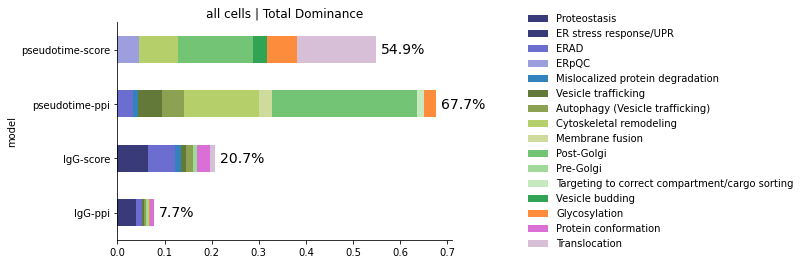

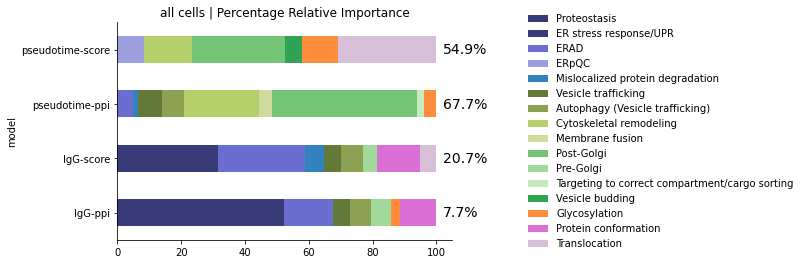

In [96]:
variance_bar_plot(dom_df_viz['all'],None,description='all cells')

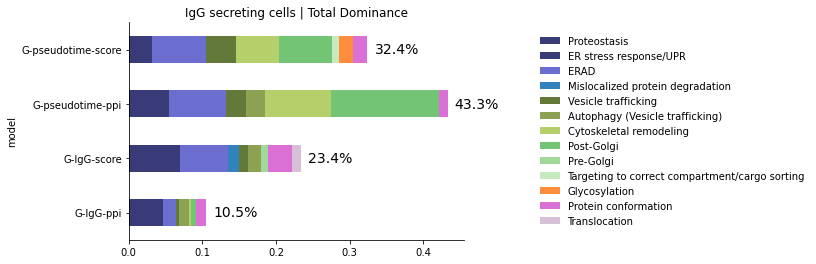

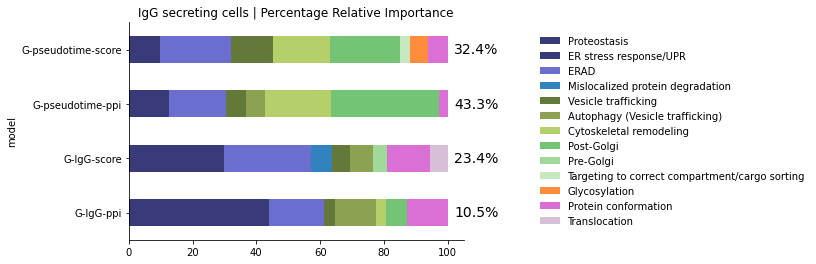

In [97]:
variance_bar_plot(dom_df_viz['G'],None,description='IgG secreting cells')

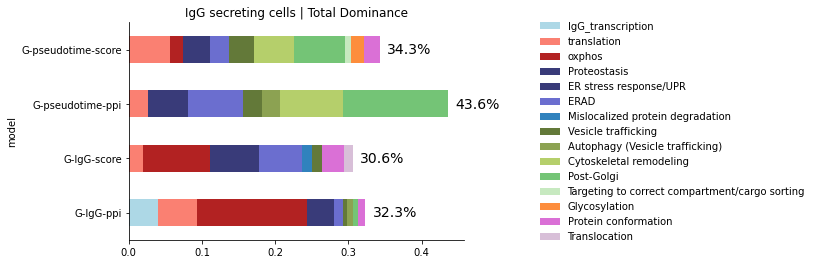

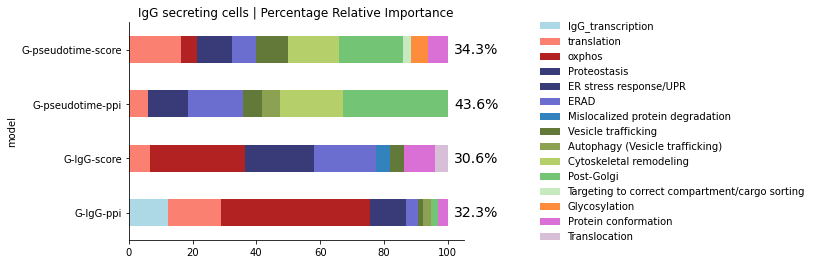

In [98]:
variance_bar_plot(dom_df_viz['G-2'],None,description='IgG secreting cells')

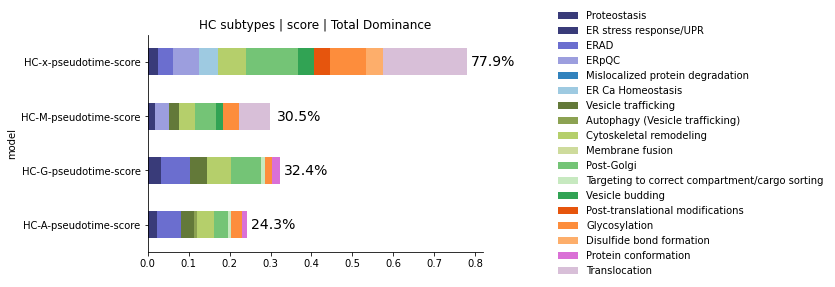

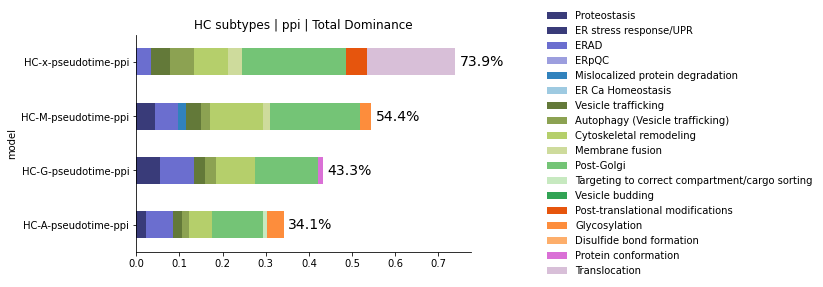

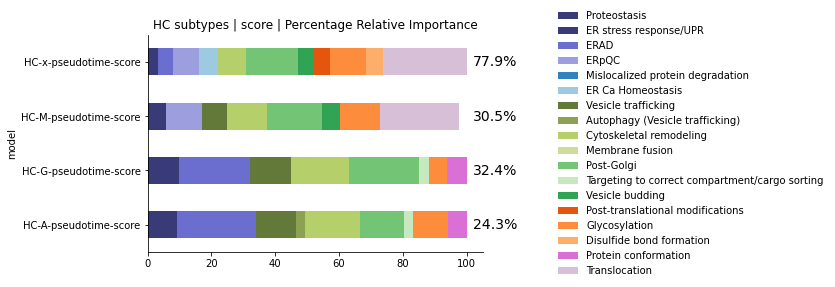

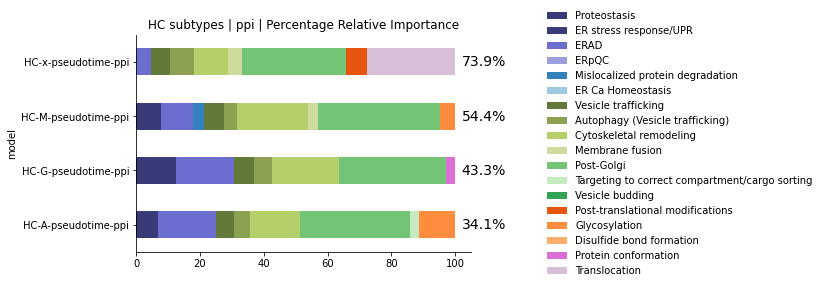

In [99]:
variance_bar_plot(dom_df_viz['HC'],hc_groups,description='HC subtypes')

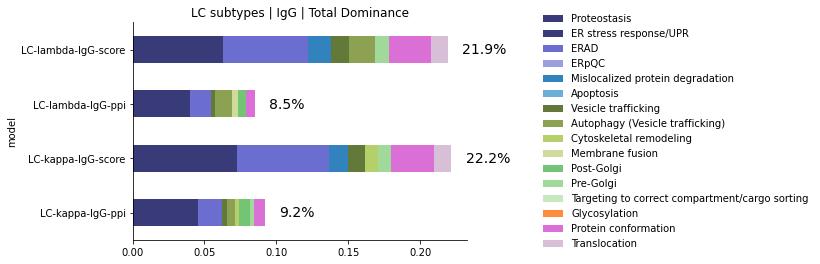

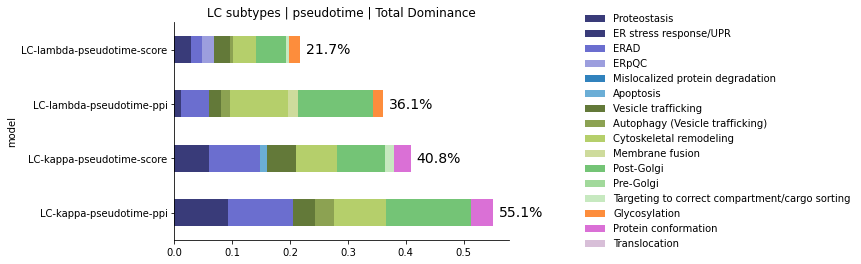

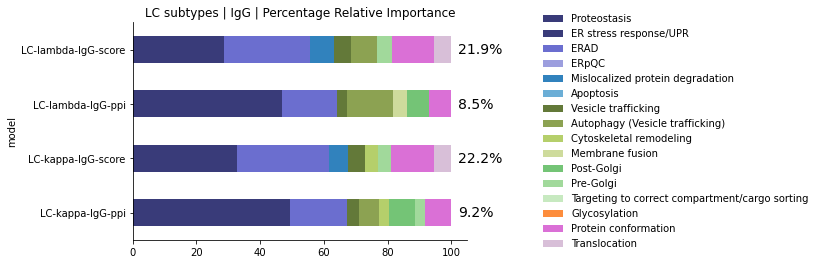

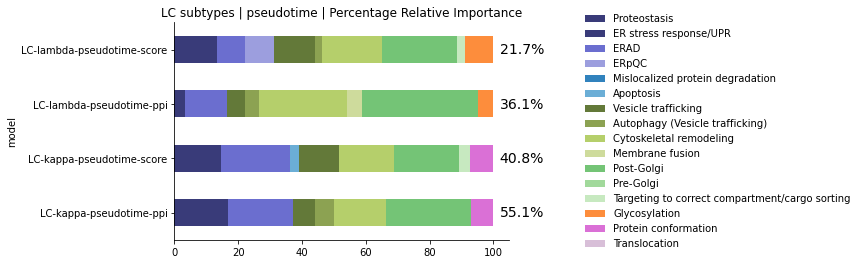

In [100]:
variance_bar_plot(dom_df_viz['LC'],lc_groups,description='LC subtypes')

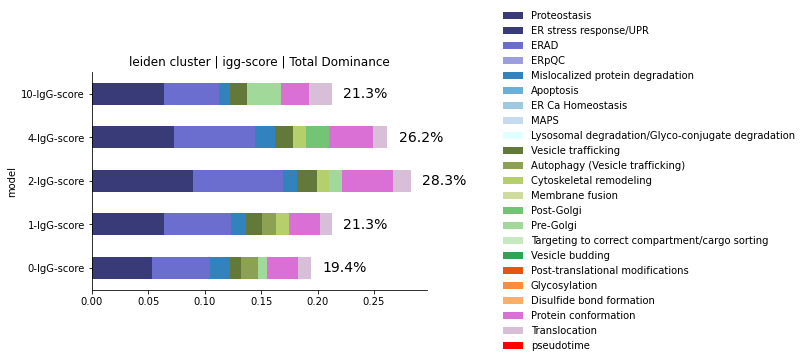

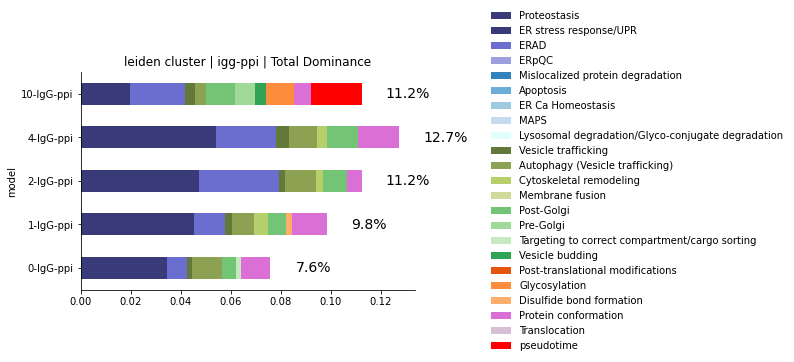

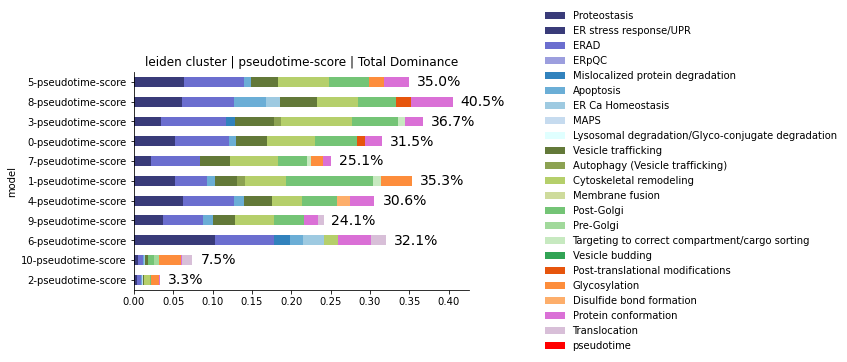

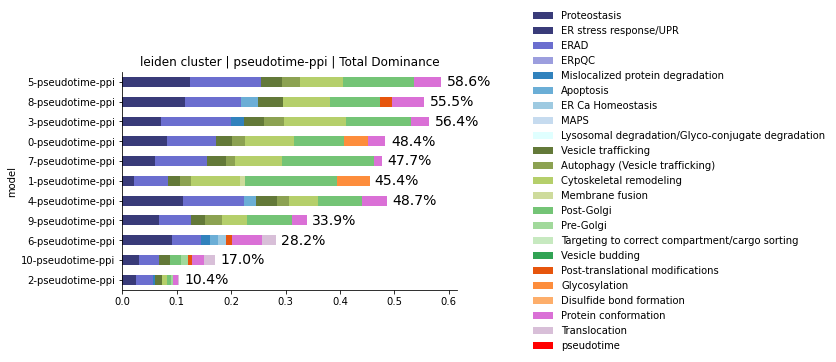

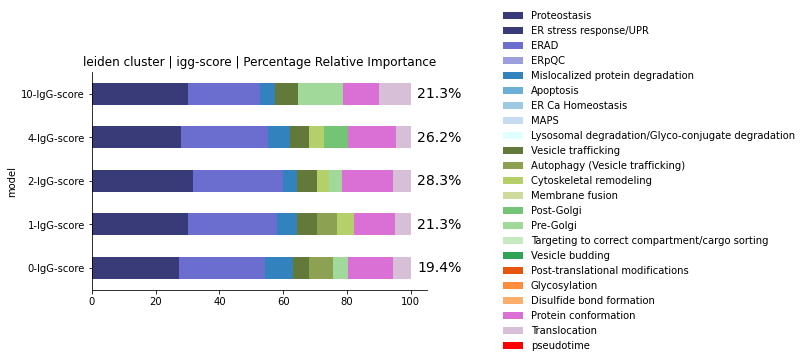

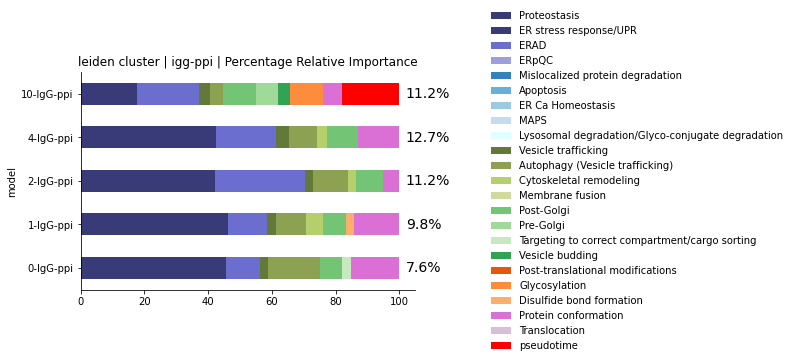

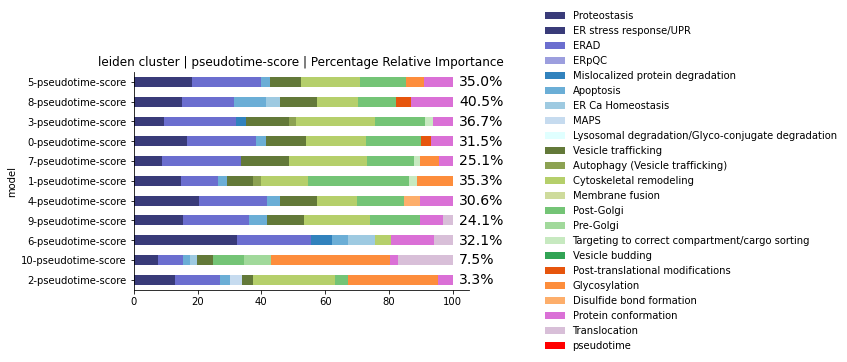

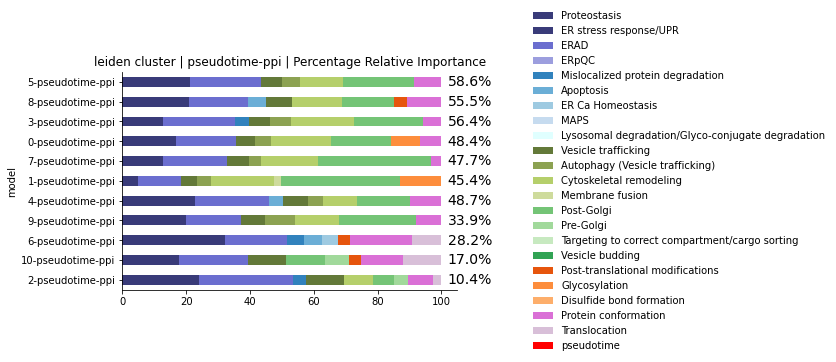

In [94]:
variance_bar_plot(dom_df_viz['cluster'],c_groups,description='leiden cluster')

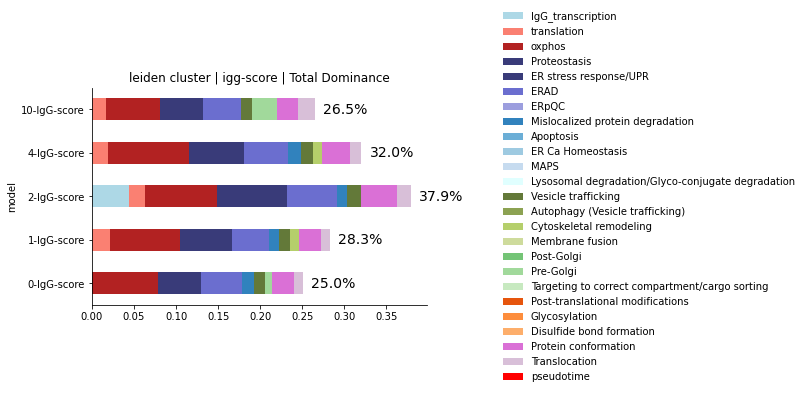

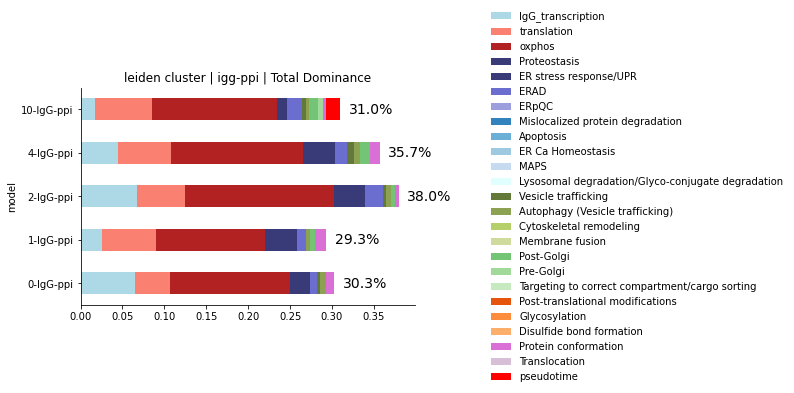

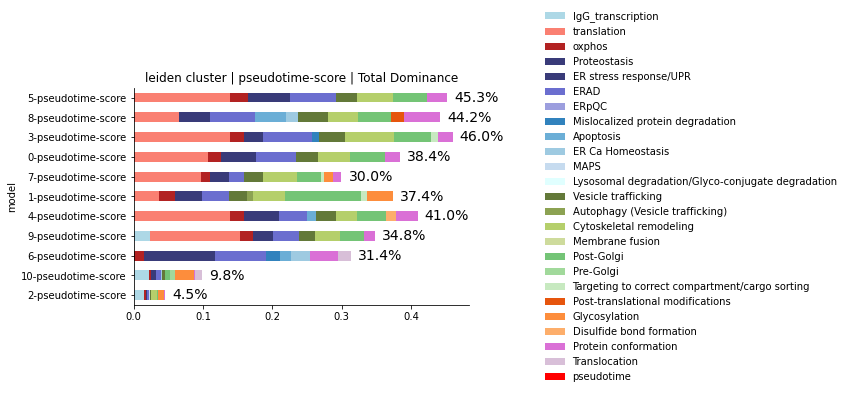

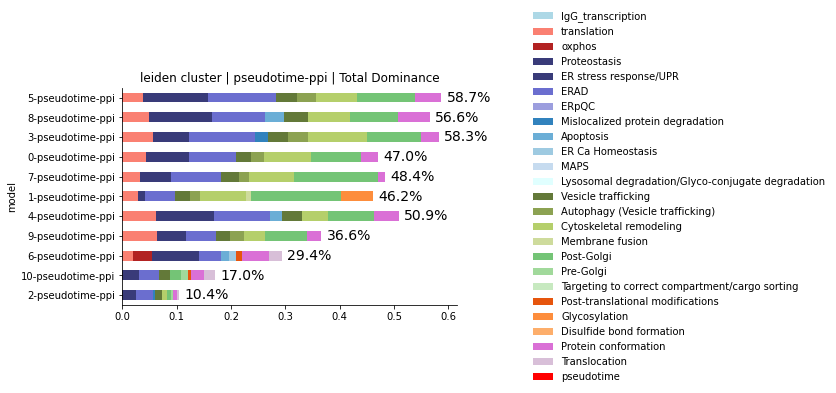

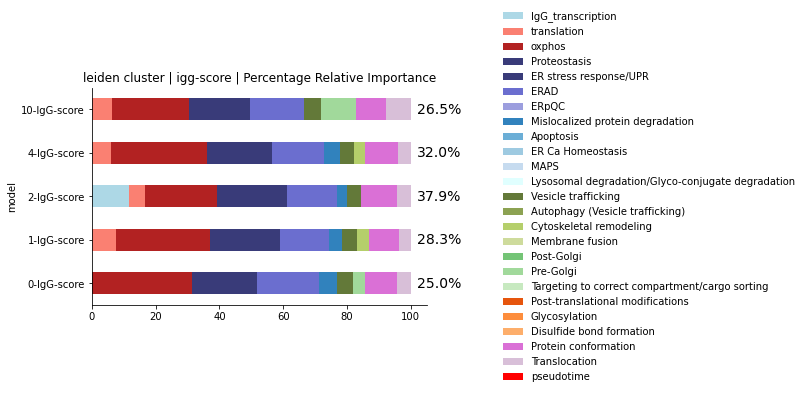

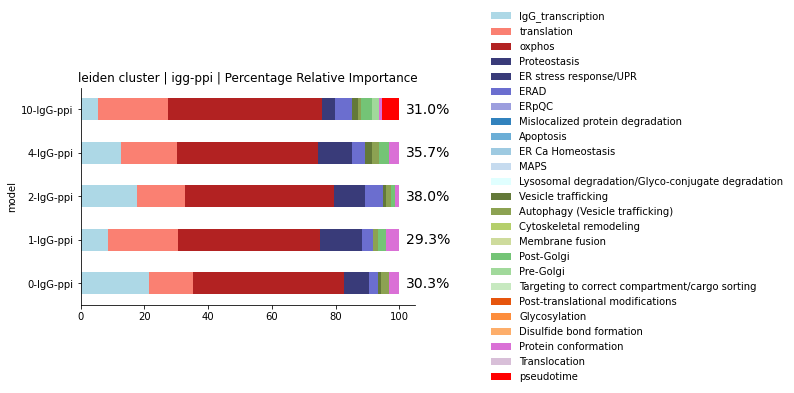

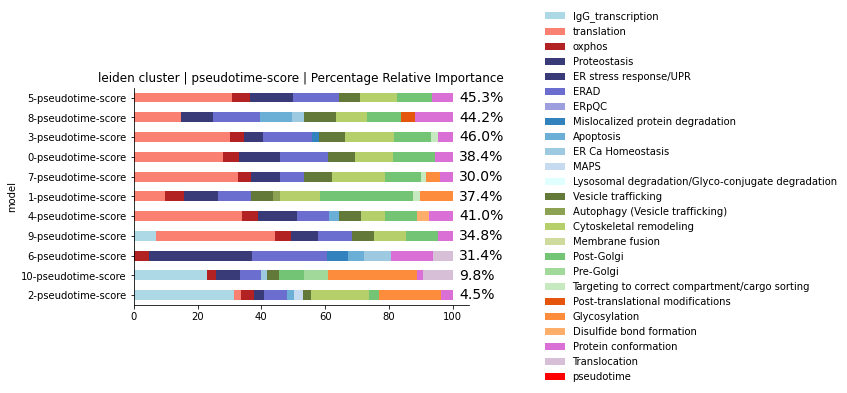

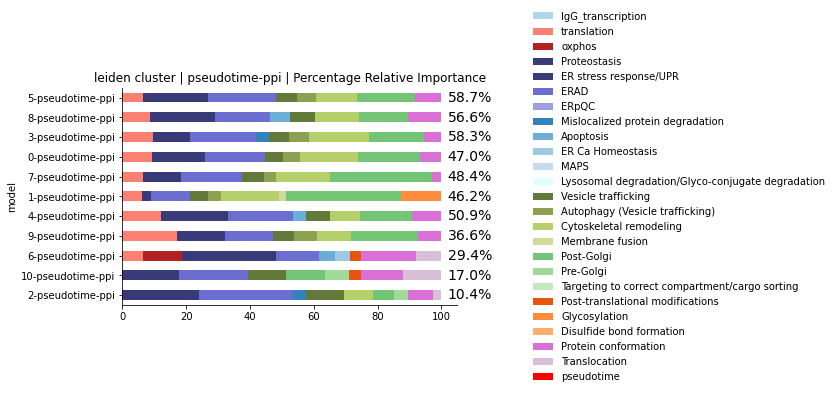

In [95]:
variance_bar_plot(dom_df_viz['cluster-2'],c_groups,description='leiden cluster')

additional downstream analysis of IgG producing leiden clusters

In [249]:
igg_clusters = ['0','1','2','4','10']

In [250]:
g_domdf = dom_df['cluster'][dom_df['cluster']['model'].isin([i+'-IgG-ppi' for i in igg_clusters])]
g_domdf

,Interactional Dominance,Individual Dominance,Average Partial Dominance,Total Dominance,Percentage Relative Importance,system,metric,response,cell_group,model,parent_term,parent_term_2
0,0.020138,0.009911,0.021206,0.020382,18.138183,dpt_pseudotime,score,ppi,10,10-IgG-ppi,pseudotime,pseudotime
1,0.017383,0.029465,0.018626,0.019266,17.144996,Ubiquitination,ppi,ppi,10,10-IgG-ppi,Proteostasis,ERAD
2,0.011992,0.008398,0.011696,0.011496,10.229938,Keratan sulfate,ppi,ppi,10,10-IgG-ppi,Post-translational modifications,Glycosylation
3,0.004608,0.027209,0.010700,0.011395,10.140108,PERK pathway,ppi,ppi,10,10-IgG-ppi,Proteostasis,ER stress response/UPR
4,0.007294,0.016237,0.009164,0.009511,8.463689,Endocytic recycling,ppi,ppi,10,10-IgG-ppi,Vesicle trafficking,Post-Golgi
...,...,...,...,...,...,...,...,...,...,...,...,...
10,0.000714,0.030239,0.002103,0.003886,3.949244,Endocytosis,ppi,ppi,1,1-IgG-ppi,Vesicle trafficking,Post-Golgi
11,0.001201,0.028497,0.001433,0.003222,3.273775,Post-Golgi,ppi,ppi,1,1-IgG-ppi,Vesicle trafficking,Post-Golgi
12,0.000166,0.028697,0.001234,0.002993,3.041714,ERAD,ppi,ppi,1,1-IgG-ppi,Proteostasis,ERAD
13,0.000337,0.027692,0.001064,0.00279,2.835627,Vesicle trafficking,ppi,ppi,1,1-IgG-ppi,Vesicle trafficking,Vesicle trafficking


In [252]:
# print the most important/predictive processes per cluster
for i in igg_clusters:
    print(i)
    print(set(g_domdf[g_domdf['cell_group'] == i]['system']))

0
{'ERAD', 'Multimerization', 'IRE1 pathway', 'PERK pathway', 'Vesicle trafficking', 'Protein conformation', 'Lysosomes', 'Autophagy (Vesicle trafficking)', 'Proteostasis', 'Protein folding', 'Post-Golgi', 'ER stress response/UPR', 'Ubiquitination', 'Targeting to correct compartment/cargo sorting', 'Retrotranslocation'}
1
{'ERAD', 'Multimerization', 'Endocytosis', 'IRE1 pathway', 'PERK pathway', 'Vesicle trafficking', 'Protein conformation', 'Autophagy (Vesicle trafficking)', 'Proteostasis', 'Protein folding', 'Post-Golgi', 'Cytoskeletal remodeling', 'ER stress response/UPR', 'Ubiquitination', 'Disulfide bond formation'}
2
{'ERAD', 'Endocytosis', 'Clathrin', 'Proteasomal degradation', 'IRE1 pathway', 'PERK pathway', 'Vesicle trafficking', 'Protein conformation', 'Autophagy (Vesicle trafficking)', 'Proteostasis', 'Post-Golgi', 'Protein folding', 'Cytoskeletal remodeling', 'ER stress response/UPR', 'Ubiquitination'}
4
{'ERAD', 'Multimerization', 'Endocytosis', 'Proteasomal degradation', 

In [144]:
# import secRecon annotations/ontology
with open('../data/t2g_dict.pickle', 'rb') as f:
    t2g_dict = pickle.load(f)
    
with open('../data/gene_dict.pkl', 'rb') as f:
    gene_dict = pickle.load(f)

# obtain all subsystems represented in this dominance analysis
g_domdf_subsys = [i for i in list(set(g_domdf['system'])) if 'pseudotime' not in i]
print(len(g_domdf_subsys),'subsystems')

# get genes within these terms
g_domdf_subsys_genes = []
for s in [*g_domdf_subsys]:
    g_domdf_subsys_genes.extend(t2g_dict[s])
g_domdf_subsys_genes = list(set(g_domdf_subsys_genes))
print(len(g_domdf_subsys_genes),'genes')

25 subsystems
855 genes


In [151]:
# obtain cluster-based avg expression of these genes
import scanpy as sc
import random
# set random seed for reproducibility
random.seed(21)

# import rna obj
rna = sc.read('../data/preprocessed_data/rna_pseudotime_ppiscore.h5')


# obtain norm expression df for 855 genes, all cells
rna_expr_sr = sc.get.obs_df(rna,keys=[g for g in g_domdf_subsys_genes if g in rna.var.index.tolist()])
rna_expr_sr

,FKBP1A,FUT8,CLTB,VAMP2,RAB2B,ACTR3,TRPV2,ARAP3,TBC1D15,RAB6B,...,PSMD9,RAB11FIP2,TMED6,RABEP1,ARHGAP1,RAB10,PSD3,TBC1D23,CHMP4C,APPL1
AAACCCAAGTACTGTC-1-0,0.698532,0.698532,0.698532,0.698532,0.000000,0.922749,0.000000,0.0,0.698532,0.0,...,0.409058,0.000000,0.0,0.409058,0.0,0.409058,0.0,0.000000,0.0,0.000000
AAACCCAAGTGAATAC-1-0,1.029481,1.525888,0.000000,0.000000,0.000000,1.525888,1.029481,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.525888,0.0,1.029481
AAACCCAGTCCACAGC-1-0,0.438586,0.000000,0.742426,0.438586,0.000000,1.163793,0.000000,0.0,0.000000,0.0,...,0.438586,0.000000,0.0,0.000000,0.0,0.438586,0.0,0.438586,0.0,0.742426
AAACCCATCACAGTGT-1-0,1.281957,0.624812,0.000000,0.000000,0.000000,1.281957,0.000000,0.0,0.000000,0.0,...,1.006420,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
AAACCCATCCCTCTCC-1-0,0.000000,0.832772,0.000000,0.000000,0.500680,0.832772,0.000000,0.0,0.500680,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCGACTCCT-1-2,0.000000,0.000000,0.000000,0.897055,0.000000,0.545914,0.000000,0.0,0.545914,0.0,...,0.545914,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
TTTGTTGAGGTACAAT-1-2,0.000000,0.000000,1.194753,0.569612,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.569612,0.569612,0.0,0.569612,0.0,0.000000,0.0,0.000000,0.0,0.000000
TTTGTTGAGTAACGAT-1-2,0.780009,0.000000,0.000000,1.019655,0.000000,1.019655,0.000000,0.0,0.000000,0.0,...,0.000000,0.780009,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
TTTGTTGCACGTTGGC-1-2,0.000000,0.000000,0.000000,0.000000,0.439152,0.439152,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.743262


generate pseudobulk groups within these leiden clusters

In [170]:
pb_group = 'leiden'
pb_ncells = 80 # approx how many cells per pseudobulk group

# this is about many pseudobulk datapoints you will get per group
## below code will automatically skip group if it has <=10 cells, then it will aggregate it into 1 group
rna.obs[pb_group].value_counts()/pb_ncells

0     31.2125
1     28.8125
2     27.9250
3     15.6375
4     12.1375
5     10.5000
6     10.2125
7      9.4250
8      6.2875
9      4.8500
10     4.1500
Name: leiden, dtype: float64

In [194]:
# make pseudobulk by specific "group"; output the pseudobulk median norm counts
pbs = {}
# pbs_sr_med = pd.DataFrame(index=rna_expr_sr.columns)

for c in igg_clusters:
    
    # get cell ids per cluster
    c_cells = rna.obs[rna.obs['leiden'] == c].index.tolist()
    
    totcells = len(c_cells)
    
    if totcells > 10:
        pbreps =  np.round(totcells/pb_ncells).astype(int)  # get N pseudobulk groups per pb_ncells cells; round number to integer
    else:
        pbreps = 1 # aggregate all cells in 1 group
        
    print(c, totcells, pbreps) # print group, # tot cells, how many pb groups are formed

    # obtain cell indices per pseudobulk group
    random.shuffle(c_cells) # randomly shuffle
    indices = np.array_split(np.array(c_cells), pbreps) #change number here for number of replicates desired; split into random groups
    
    for i, pseudo_rep in enumerate(indices):
        
        # subset object per pb group
        ind_subset = rna_expr_sr.loc[pseudo_rep.tolist(),:].copy()
        
        # avg across cells
        rep_mean = ind_subset.mean(axis=0)
        
        pbs[c + '_' + str(i)] = rep_mean
        
pbs_sr_med = pd.DataFrame.from_dict(pbs)
print(pbs_sr_med.shape)

# remove zero expr genes
pbs_sr_med = pbs_sr_med[pbs_sr_med.sum(axis=1) != 0]
print(pbs_sr_med.shape)

pbs_sr_med

0 2497 31
1 2305 29
2 2234 28
4 971 12
10 332 4
(831, 104)
(787, 104)


,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,4_6,4_7,4_8,4_9,4_10,4_11,10_0,10_1,10_2,10_3
FKBP1A,0.219392,0.291315,0.226506,0.278929,0.326869,0.309656,0.247068,0.297451,0.268780,0.320649,...,0.269919,0.163729,0.234546,0.180044,0.238681,0.225805,0.152578,0.149673,0.167982,0.224764
FUT8,0.448914,0.506260,0.436180,0.449656,0.429112,0.326226,0.452796,0.408436,0.536489,0.361964,...,0.451664,0.498419,0.439643,0.514433,0.432090,0.313364,0.357469,0.307166,0.408162,0.355763
CLTB,0.255132,0.184968,0.300459,0.249114,0.276107,0.231400,0.279340,0.314842,0.257125,0.305551,...,0.264668,0.301268,0.201373,0.255725,0.254480,0.259756,0.230691,0.196278,0.262589,0.229082
VAMP2,0.387337,0.356084,0.420427,0.351092,0.341944,0.306893,0.470522,0.438514,0.495568,0.513440,...,0.392225,0.497332,0.273248,0.349093,0.381805,0.363990,0.374377,0.360757,0.266722,0.273206
RAB2B,0.076728,0.076660,0.112964,0.109320,0.070622,0.077336,0.109207,0.070892,0.047623,0.059893,...,0.080418,0.087977,0.065133,0.048757,0.075847,0.089937,0.051634,0.081645,0.077694,0.039736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RAB10,0.217073,0.222366,0.218912,0.224759,0.259995,0.320012,0.198819,0.201341,0.306006,0.300525,...,0.273569,0.199610,0.285700,0.209821,0.201745,0.294896,0.229436,0.161549,0.230012,0.190833
PSD3,0.000000,0.000000,0.005621,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TBC1D23,0.093442,0.088837,0.097327,0.093970,0.080407,0.105495,0.099641,0.141592,0.132050,0.051656,...,0.042580,0.108990,0.124625,0.087789,0.135026,0.037296,0.078772,0.020175,0.031199,0.051281
CHMP4C,0.000000,0.000000,0.000000,0.000000,0.000000,0.019520,0.015816,0.000000,0.024251,0.007121,...,0.000000,0.000000,0.000000,0.021330,0.000000,0.010995,0.009000,0.008648,0.000000,0.000000


In [219]:
# remove genes that are all 0 in each cluster's pseudobulk groups ## 80 total genes
genes_rm = []

for i in igg_clusters:
    i_df = pbs_sr_med[[c for c in pbs_sr_med.columns if c.split('_')[0] == i]].copy()
    
    i_g  = list(i_df.index[i_df.sum(axis=1) == 0])
    print(i,len(i_g))
    
    genes_rm.extend(i_g)
    
genes_rm = list(set(genes_rm))
print(len(genes_rm))

0 20
1 12
2 28
4 48
10 76
80


In [224]:
pbs_sr_med_flt = pbs_sr_med[~pbs_sr_med.index.isin(genes_rm)]
pbs_sr_med_flt

,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,4_6,4_7,4_8,4_9,4_10,4_11,10_0,10_1,10_2,10_3
FKBP1A,0.219392,0.291315,0.226506,0.278929,0.326869,0.309656,0.247068,0.297451,0.268780,0.320649,...,0.269919,0.163729,0.234546,0.180044,0.238681,0.225805,0.152578,0.149673,0.167982,0.224764
FUT8,0.448914,0.506260,0.436180,0.449656,0.429112,0.326226,0.452796,0.408436,0.536489,0.361964,...,0.451664,0.498419,0.439643,0.514433,0.432090,0.313364,0.357469,0.307166,0.408162,0.355763
CLTB,0.255132,0.184968,0.300459,0.249114,0.276107,0.231400,0.279340,0.314842,0.257125,0.305551,...,0.264668,0.301268,0.201373,0.255725,0.254480,0.259756,0.230691,0.196278,0.262589,0.229082
VAMP2,0.387337,0.356084,0.420427,0.351092,0.341944,0.306893,0.470522,0.438514,0.495568,0.513440,...,0.392225,0.497332,0.273248,0.349093,0.381805,0.363990,0.374377,0.360757,0.266722,0.273206
RAB2B,0.076728,0.076660,0.112964,0.109320,0.070622,0.077336,0.109207,0.070892,0.047623,0.059893,...,0.080418,0.087977,0.065133,0.048757,0.075847,0.089937,0.051634,0.081645,0.077694,0.039736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ARHGAP1,0.057657,0.047931,0.009213,0.053660,0.038886,0.014576,0.043990,0.009323,0.038749,0.068758,...,0.011574,0.069620,0.059620,0.060301,0.050843,0.028895,0.043193,0.020572,0.016975,0.027270
RAB10,0.217073,0.222366,0.218912,0.224759,0.259995,0.320012,0.198819,0.201341,0.306006,0.300525,...,0.273569,0.199610,0.285700,0.209821,0.201745,0.294896,0.229436,0.161549,0.230012,0.190833
TBC1D23,0.093442,0.088837,0.097327,0.093970,0.080407,0.105495,0.099641,0.141592,0.132050,0.051656,...,0.042580,0.108990,0.124625,0.087789,0.135026,0.037296,0.078772,0.020175,0.031199,0.051281
CHMP4C,0.000000,0.000000,0.000000,0.000000,0.000000,0.019520,0.015816,0.000000,0.024251,0.007121,...,0.000000,0.000000,0.000000,0.021330,0.000000,0.010995,0.009000,0.008648,0.000000,0.000000


In [186]:
from sklearn.metrics.pairwise import cosine_similarity

In [229]:
[*t2g_dict]

['Proteostasis',
 'Protein conformation',
 'Glycerophospholipid (GPI anchor)',
 'COPII',
 'Carboxylase',
 'Keratan sulfate',
 'ER Ca Homeostasis',
 'Retrotranslocation',
 'O-glycan not-mucin',
 'Mislocalized protein degradation',
 'Hydroxylysine',
 'PERK pathway',
 'O-glycan mucin',
 'Multimerization',
 'Acetyltransferase',
 'Carboxylation',
 'Apoptosis',
 'IRE1 pathway',
 'Phosphorylation',
 'Dermatan sulfate',
 'MAPS',
 'Golgi to PM',
 'SLC nucleotide-sugar transporter',
 'Vesicle trafficking',
 'Kinase',
 'Endocytosis',
 'Post-translational modifications',
 'Lysosomal degradation/Glyco-conjugate degradation',
 'ER stress response/UPR',
 'COPI',
 'SLC acetyl-CoA transporter',
 'Autophagy (Vesicle trafficking)',
 'Hyaluronic acid',
 'Post-Golgi',
 'Globo series',
 'Protein folding',
 'Targeting to correct compartment/cargo sorting',
 'Clathrin',
 'Proteasomal degradation',
 'Lacto/neolacto series',
 'Autophagy (Proteostasis)',
 'N-glycan',
 'Chondroitin sulfate',
 'O-glycan',
 'Pre-Go

In [233]:
# export genes annotated within proteostasis

upr_g = list(set(pbs_sr_med_flt.index) & set(t2g_dict['ER stress response/UPR']))
len(upr_g)

pbs_sr_med_flt_upr = pbs_sr_med_flt.loc[upr_g,:]
pbs_sr_med_flt_upr.shape

(82, 104)

In [234]:
# export df to csv ## leverage for corrplot and dendrogram analysis in R 4_IgGpopulation_correlation.Rmd
pbs_sr_med_flt.to_csv('../data/dominance_analysis/igg_cluster_pseudobulk_secrecon_mean.csv')
pbs_sr_med_flt_upr.to_csv('../data/dominance_analysis/igg_cluster_pseudobulk_secrecon_mean_upr.csv')

In [179]:
# get median expression for each IgG cluster
rna_expr_sr_c = {}

for c in igg_clusters:
    
    # get cell ids per cluster
    c_cells = rna.obs[rna.obs['leiden'] == c].index.tolist()
    
    # subset expr df and get median expr for each gene
    rna_expr_sr_c[c] = rna_expr_sr.loc[c_cells,:].median()
    
# convert to dataframe 
rna_expr_sr_cluster = pd.DataFrame.from_dict(rna_expr_sr_c)
print(rna_expr_sr_cluster.shape)

# remove genes that have 0 expression in all groups
rna_expr_sr_cluster = rna_expr_sr_cluster[rna_expr_sr_cluster.sum(axis=1) != 0]
print(rna_expr_sr_cluster.shape)

# add secRecon process annotation per gene
gtemp = []
for i in rna_expr_sr_cluster.index.tolist():
    if len(gene_dict[i]['systems']) > 1:
#         print(i,gene_dict[i]['systems'])
        gtemp.append('multi')
    else:
        gtemp.append(gene_dict[i]['systems'][0])
rna_expr_sr_cluster['term'] = gtemp
rna_expr_sr_cluster

(831, 5)
(160, 5)


,0,1,2,4,10,term
FUT8,0.412748,0.480967,0.000000,0.000000,0.000000,Post-translational modifications
VAMP2,0.356853,0.389319,0.000000,0.000000,0.000000,Vesicle trafficking
ACTR3,0.591665,0.707029,0.000000,0.000000,0.000000,Vesicle trafficking
SDF2L1,1.304208,1.284125,1.048978,1.260801,1.054246,multi
UBE2J1,1.224652,1.350514,0.909888,1.152818,0.881519,Proteostasis
...,...,...,...,...,...,...
CCT8,0.658536,0.736845,0.430545,0.605402,0.521130,multi
TRAPPC5,0.620257,0.699766,0.276793,0.620479,0.518102,Vesicle trafficking
FKBP3,0.384679,0.514883,0.000000,0.000000,0.000000,Protein conformation
PSMD7,0.656363,0.697553,0.477942,0.604803,0.548133,Proteostasis


In [173]:
rna_expr_sr_cluster.to_csv('../data/dominance_analysis/igg_cluster_aggr_secrecon_median.csv')

In [175]:
import seaborn as sns

# define a function to draw the y=x line on the current plot

def equalityline(x, y, **kwargs):
    x0, x1 = min(x), max(x)
    y0, y1 = min(y), max(y)
    lims = [min(x0, y0), max(x1, y1)]
    plt.plot(lims, lims, **kwargs)

In [180]:
rna_expr_sr_cluster[igg_clusters]

,0,1,2,4,10
FUT8,0.412748,0.480967,0.000000,0.000000,0.000000
VAMP2,0.356853,0.389319,0.000000,0.000000,0.000000
ACTR3,0.591665,0.707029,0.000000,0.000000,0.000000
SDF2L1,1.304208,1.284125,1.048978,1.260801,1.054246
UBE2J1,1.224652,1.350514,0.909888,1.152818,0.881519
...,...,...,...,...,...
CCT8,0.658536,0.736845,0.430545,0.605402,0.521130
TRAPPC5,0.620257,0.699766,0.276793,0.620479,0.518102
FKBP3,0.384679,0.514883,0.000000,0.000000,0.000000
PSMD7,0.656363,0.697553,0.477942,0.604803,0.548133


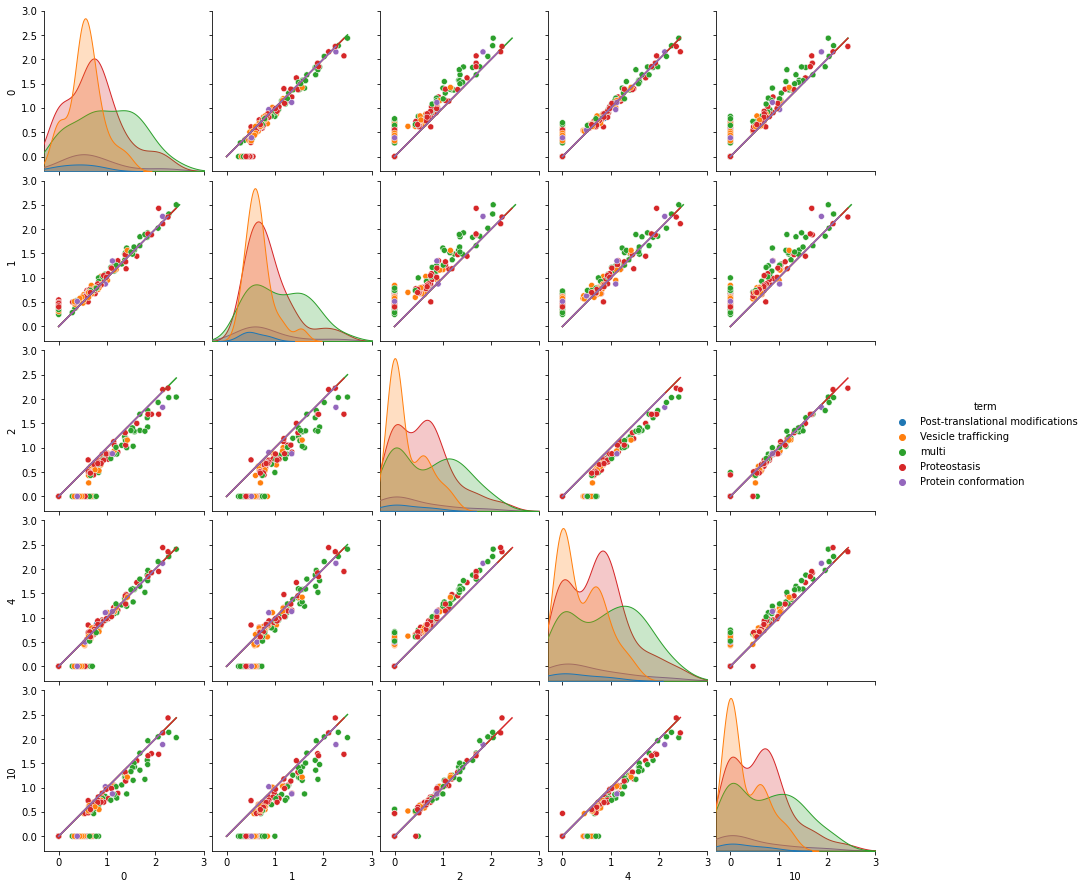

In [182]:
# pairwise scatter/correlation of secRecon median expr
spp = sns.pairplot(rna_expr_sr_cluster,hue='term')
spp.map_offdiag(equalityline)
spp.set(xlim=(-0.3,3), ylim = (-0.3,3))

In [135]:
# all secRecon subsystems (top 15) for each IgG cluster
for g in igg_clusters:
    g_rest = [i for i in igg_clusters if i != g]
    g_sys = g_domdf[g_domdf['cell_group'] == g]['system'].values
    print(g)
    print(g_sys)
    print('\n')

0
['PERK pathway' 'Autophagy (Vesicle trafficking)' 'IRE1 pathway'
 'ER stress response/UPR' 'Multimerization' 'Protein folding'
 'Ubiquitination' 'Protein conformation' 'Post-Golgi' 'Lysosomes'
 'Proteostasis' 'Retrotranslocation' 'ERAD'
 'Targeting to correct compartment/cargo sorting' 'Vesicle trafficking']


1
['PERK pathway' 'IRE1 pathway' 'Ubiquitination'
 'Autophagy (Vesicle trafficking)' 'ER stress response/UPR'
 'Cytoskeletal remodeling' 'Protein folding' 'Protein conformation'
 'Multimerization' 'Proteostasis' 'Endocytosis' 'Post-Golgi' 'ERAD'
 'Vesicle trafficking' 'Disulfide bond formation']


2
['PERK pathway' 'Ubiquitination' 'Autophagy (Vesicle trafficking)'
 'IRE1 pathway' 'ER stress response/UPR' 'Proteostasis' 'ERAD'
 'Post-Golgi' 'Clathrin' 'Protein conformation' 'Protein folding'
 'Cytoskeletal remodeling' 'Vesicle trafficking' 'Proteasomal degradation'
 'Endocytosis']


4
['PERK pathway' 'Autophagy (Vesicle trafficking)' 'IRE1 pathway'
 'Ubiquitination' 'ERAD' 'ER 

In [133]:
# unique secRecon subsystems for each IgG cluster
for g in igg_clusters:
    g_rest = [i for i in igg_clusters if i != g]
    g_uniq = set(g_domdf[g_domdf['cell_group'] == g]['system']) - set(g_domdf[g_domdf['cell_group'].isin(g_rest)]['system'])
    print(g)
    print(g_uniq)
    print('\n')

0
{'Targeting to correct compartment/cargo sorting', 'Retrotranslocation', 'Lysosomes'}


1
{'Disulfide bond formation'}


2
{'Clathrin'}


4
set()


10
{'Keratan sulfate', 'Pre-Golgi', 'Vesicle budding', 'dpt_pseudotime', 'ER to Golgi (anterograde)', 'Endocytic recycling'}


